In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

print("Music Trends by Country - Data Collection Started")
print("=" * 60)

def load_country_dataset():
    try:
        df_countries = pd.read_csv('universal_top_spotify_songs.csv')
        print(f"Country Dataset Loaded: {df_countries.shape[0]} rows, {df_countries.shape[1]} columns")
        return df_countries
    except FileNotFoundError:
        print("Country dataset not found. Please download from Kaggle:")
        print("https://www.kaggle.com/datasets/asaniczka/top-spotify-songs-in-73-countries-daily-updated")
        return None

def load_genre_dataset():
    try:
        df_genres = pd.read_csv('train.csv')
        print(f"Genre Dataset Loaded: {df_genres.shape[0]} rows, {df_genres.shape[1]} columns")
        return df_genres
    except FileNotFoundError:
        print("Genre dataset not found. Please download from Kaggle:")
        print("https://www.kaggle.com/datasets/thedevastator/spotify-tracks-genre-dataset")
        return None

df_countries = load_country_dataset()
df_genres = load_genre_dataset()

if df_countries is not None:
    print("\nCOUNTRY DATASET - First Look:")
    print(df_countries.head())
    print(f"\nColumns: {list(df_countries.columns)}")

if df_genres is not None:
    print("\nGENRE DATASET - First Look:")
    print(df_genres.head())
    print(f"\nColumns: {list(df_genres.columns)}")

Music Trends by Country - Data Collection Started
Country Dataset Loaded: 2110316 rows, 25 columns
Genre Dataset Loaded: 114000 rows, 21 columns

COUNTRY DATASET - First Look:
               spotify_id                name                artists  \
0  2RkZ5LkEzeHGRsmDqKwmaJ            Ordinary            Alex Warren   
1  42UBPzRMh5yyz0EDPr6fr1            Manchild      Sabrina Carpenter   
2  0FTmksd2dxiE5e3rWyJXs6     back to friends                  sombr   
3  7so0lgd0zP2Sbgs2d7a1SZ    Die With A Smile  Lady Gaga, Bruno Mars   
4  6dOtVTDdiauQNBQEDOtlAB  BIRDS OF A FEATHER          Billie Eilish   

   daily_rank  daily_movement  weekly_movement country snapshot_date  \
0           1               1                0     NaN    2025-06-11   
1           2              -1               48     NaN    2025-06-11   
2           3               0                1     NaN    2025-06-11   
3           4               0               -1     NaN    2025-06-11   
4           5               1  

In [ ]:
#Data prepocessing
import pandas as pd
import numpy as np
import pycountry
import warnings
warnings.filterwarnings('ignore')

def load_country_dataset():
    try:
        df_countries = pd.read_csv('universal_top_spotify_songs.csv')
        print(f"Country Dataset Loaded: {df_countries.shape[0]} rows, {df_countries.shape[1]} columns")
        return df_countries
    except FileNotFoundError:
        print("Country dataset not found.")
        return None

def load_genre_dataset():
    try:
        df_genres = pd.read_csv('train.csv')
        print(f"Genre Dataset Loaded: {df_genres.shape[0]} rows, {df_genres.shape[1]} columns")
        return df_genres
    except FileNotFoundError:
        print("Genre dataset not found. ")
        return None

def clean_dataset(df, dataset_name):
    if df is None:
        print(f"Skipping cleaning for {dataset_name} as data was not loaded.")
        return None

    print(f"\nDATA CLEANING - {dataset_name}")
    print("=" * 50)

    original_shape = df.shape
    print(f"Original shape: {original_shape}")

    # Handle missing values
    print("\nMISSING VALUES:")
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing_Count': missing_data,
        'Missing_Percentage': missing_percentage
    }).sort_values('Missing_Percentage', ascending=False)

    print(missing_info[missing_info['Missing_Count'] > 0])

    for column in df.columns:
        if df[column].isnull().sum() > 0:
            if df[column].dtype in ['object', 'string']:
                mode_value = df[column].mode().iloc[0] if len(df[column].mode()) > 0 else 'Unknown'
                df[column].fillna(mode_value, inplace=True)
                print(f"Filled {column} with mode: {mode_value}")
            else:
                median_value = df[column].median()
                df[column].fillna(median_value, inplace=True)
                print(f"Filled {column} with median: {median_value:.2f}")

    # Remove duplicates
    print("\nDUPLICATE REMOVAL:")
    duplicates_before = df.duplicated().sum()
    df_cleaned = df.drop_duplicates()
    duplicates_removed = duplicates_before
    print(f"Duplicates found and removed: {duplicates_removed}")

    # Data type standardization
    print("\nDATA TYPE STANDARDIZATION:")
    for column in df_cleaned.columns:
        if df_cleaned[column].dtype == 'object':
            try:
                pd.to_numeric(df_cleaned[column], errors='raise')
                df_cleaned[column] = pd.to_numeric(df_cleaned[column])
                print(f"Converted {column} to numeric")
            except:
                df_cleaned[column] = df_cleaned[column].astype(str).str.strip()
                print(f"Cleaned {column} as string")

    # Outlier handling
    print("\nOUTLIER DETECTION:")
    numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns

    for column in numerical_columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
        outliers_count = len(outliers)

        if outliers_count > 0:
            print(f"{column}: {outliers_count} outliers detected")
            df_cleaned[column] = np.clip(df_cleaned[column], lower_bound, upper_bound)

    final_shape = df_cleaned.shape
    print(f"\nFinal shape: {final_shape}")
    print(f"Rows removed: {original_shape[0] - final_shape[0]}")
    print(f"Data retained: {((final_shape[0]/original_shape[0])*100):.1f}%")

    return df_cleaned

def convert_country_code(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return code

# Load datasets
df_countries = load_country_dataset()
df_genres = load_genre_dataset()

# Clean datasets
df_countries_clean = clean_dataset(df_countries, "COUNTRIES")
df_genres_clean = clean_dataset(df_genres, "GENRES")

# Convert country codes to full names and save final datasets
if df_countries_clean is not None and 'country' in df_countries_clean.columns:
    print("\nCOUNTRY CODE CONVERSION:")
    print("Before conversion:", df_countries_clean['country'].unique())

    df_countries_clean['country'] = df_countries_clean['country'].apply(convert_country_code)

    print("After conversion:", df_countries_clean['country'].unique())

# Save final cleaned datasets
if df_countries_clean is not None:
    df_countries_clean.to_csv("cleaned_countries_data.csv", index=False)
    print("Cleaned COUNTRIES data saved to 'cleaned_countries_data.csv'")

if df_genres_clean is not None:
    df_genres_clean.to_csv("cleaned_genres_data.csv", index=False)
    print("Cleaned GENRES data saved to 'cleaned_genres_data.csv'")

Country Dataset Loaded: 2110316 rows, 25 columns
Genre Dataset Loaded: 114000 rows, 21 columns

DATA CLEANING - COUNTRIES
Original shape: (2110316, 25)

MISSING VALUES:
                    Missing_Count  Missing_Percentage
country                     28908            1.369842
album_name                    822            0.038952
album_release_date            659            0.031228
name                           30            0.001422
artists                        29            0.001374
Filled name with mode: BIRDS OF A FEATHER
Filled artists with mode: Billie Eilish
Filled country with mode: DO
Filled album_name with mode: HIT ME HARD AND SOFT
Filled album_release_date with mode: 2024-05-17

DUPLICATE REMOVAL:
Duplicates found and removed: 6

DATA TYPE STANDARDIZATION:
Cleaned spotify_id as string
Cleaned name as string
Cleaned artists as string
Cleaned country as string
Cleaned snapshot_date as string
Cleaned album_name as string
Cleaned album_release_date as string

OUTLIER DETECTI


EXPLORATORY DATA ANALYSIS - COUNTRIES
BASIC STATISTICS:
         daily_rank  daily_movement  weekly_movement    popularity  \
count  2.110310e+06    2.110310e+06     2.110310e+06  2.110310e+06   
mean   2.549309e+01    2.834700e-01     1.493923e+00  7.610850e+01   
std    1.442897e+01    3.191332e+00     8.087797e+00  1.498776e+01   
min    1.000000e+00   -5.500000e+00    -1.500000e+01  3.050000e+01   
25%    1.300000e+01   -1.000000e+00    -3.000000e+00  6.500000e+01   
50%    2.500000e+01    0.000000e+00     0.000000e+00  7.900000e+01   
75%    3.800000e+01    2.000000e+00     5.000000e+00  8.800000e+01   
max    5.000000e+01    6.500000e+00     1.700000e+01  1.000000e+02   

        duration_ms  danceability        energy           key      loudness  \
count  2.110310e+06  2.110310e+06  2.110310e+06  2.110310e+06  2.110310e+06   
mean   1.927786e+05  6.766515e-01  6.508465e-01  5.526497e+00 -6.480788e+00   
std    4.363792e+04  1.417208e-01  1.628824e-01  3.594983e+00  2.462328e+00

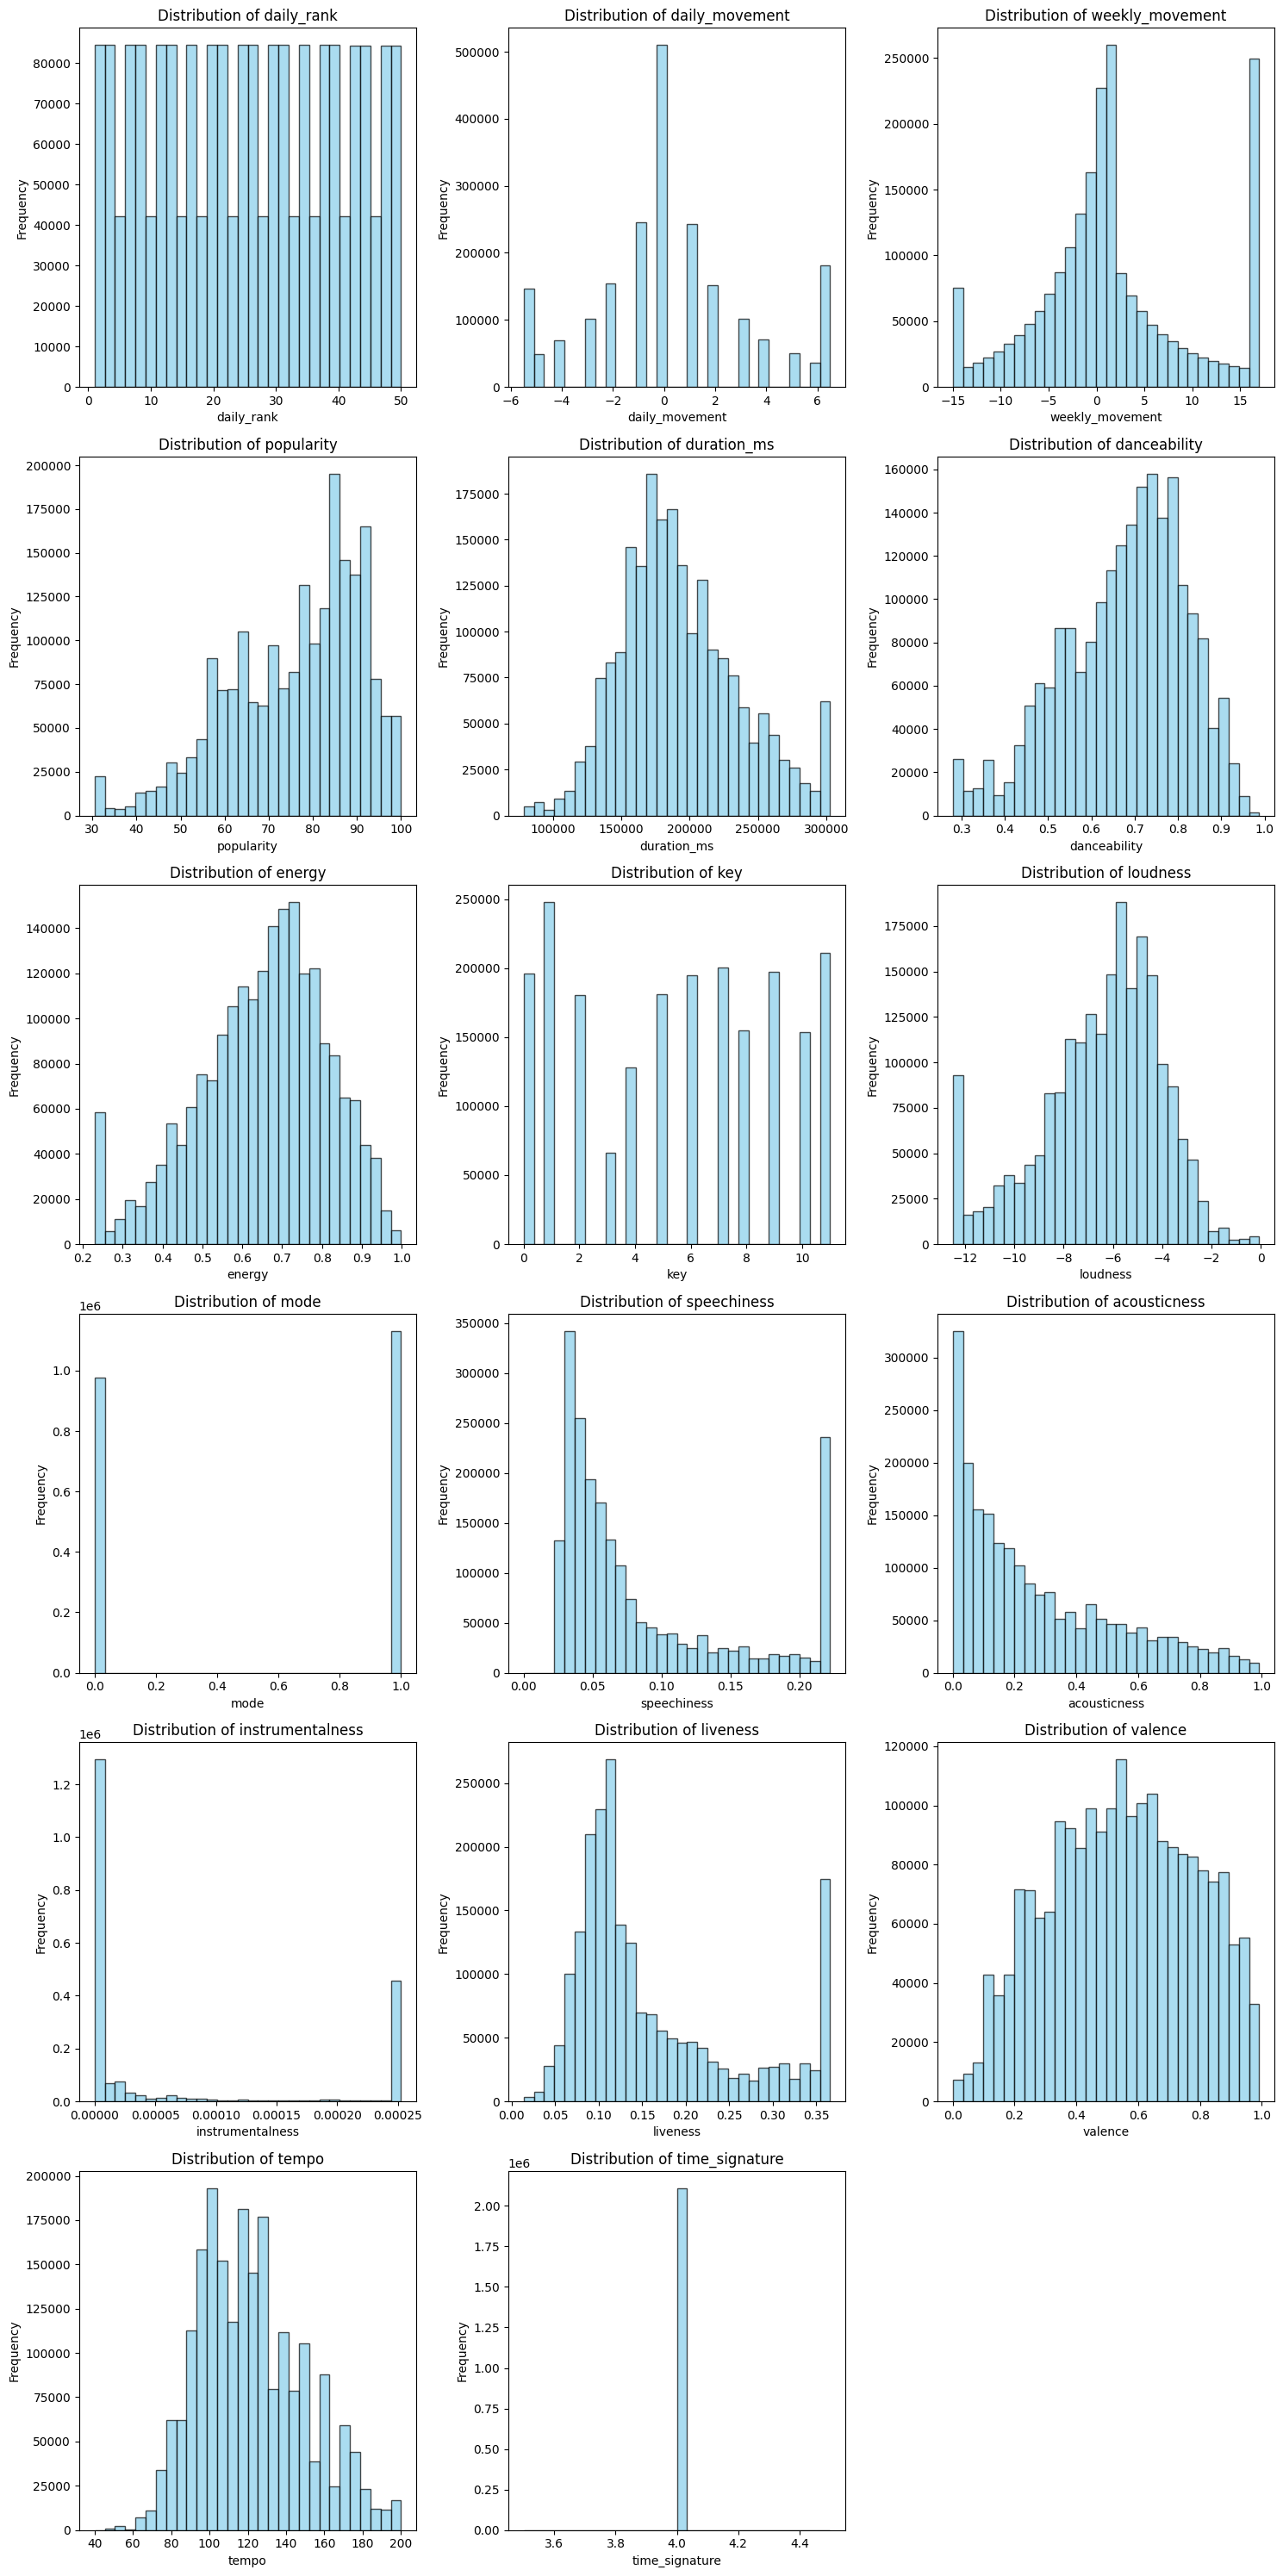


CORRELATION ANALYSIS:


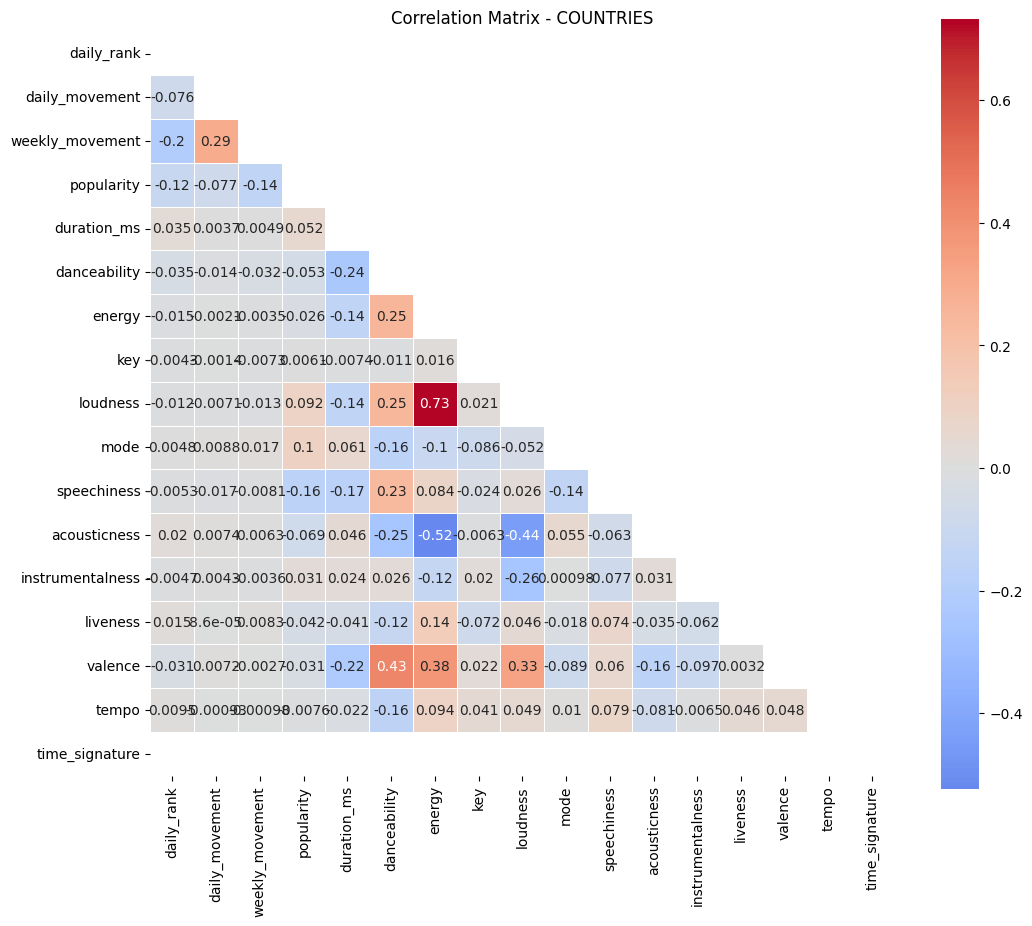

High correlation pairs (>0.7):
   energy - loudness: 0.733

CATEGORICAL DATA ANALYSIS:

spotify_id - Value Counts:
spotify_id
6dOtVTDdiauQNBQEDOtlAB    16673
2plbrEY59IikOBgBGLjaoe    12096
17phhZDn6oGtzMe56NuWvj    11716
3xkHsmpQCBMytMJNiDf3Ii    10641
7bywjHOc0wSjGGbj04XbVi     9243
7tI8dRuH2Yc6RuoTjxo4dU     8905
3rUGC1vUpkDG9CZFHMur1t     8523
4wJ5Qq0jBN4ajy7ouZIV1c     8353
6WatFBLVB0x077xWeoVc2k     8023
2qSkIjg1o9h3YT9RAgYN75     7755
Name: count, dtype: int64


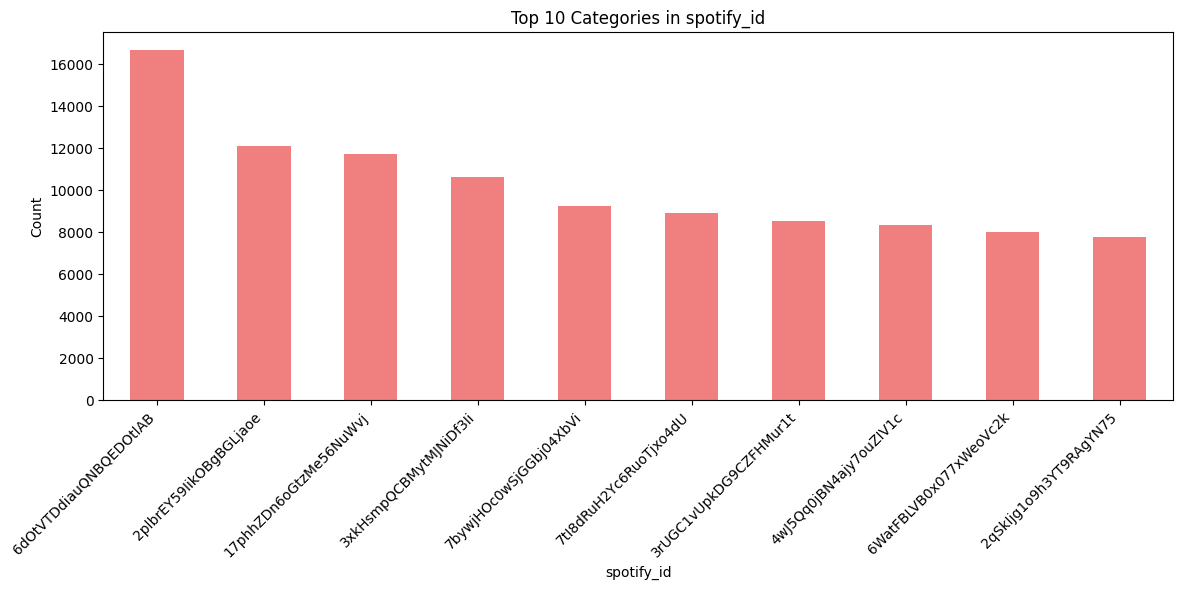


name - Value Counts:
name
BIRDS OF A FEATHER    16703
Die With A Smile      16364
Beautiful Things      13457
Espresso              13411
Lose Control          11716
APT.                  10753
LUNA                   9259
Who                    8905
greedy                 8529
Too Sweet              8196
Name: count, dtype: int64


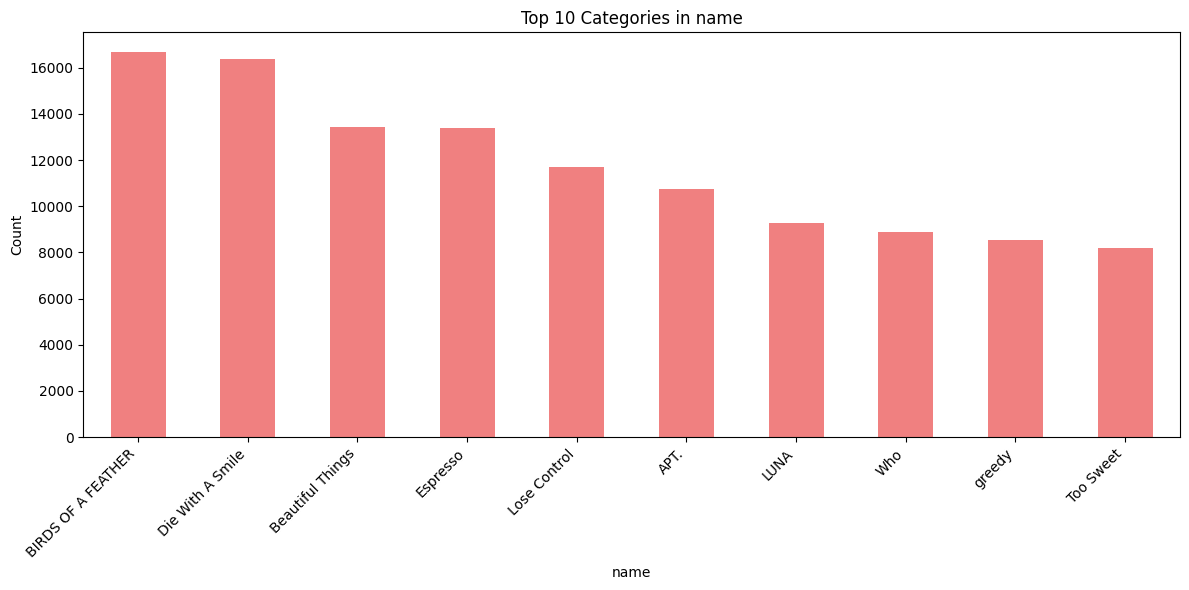


artists - Value Counts:
artists
Billie Eilish            32616
Bad Bunny                31898
Sabrina Carpenter        29042
KAROL G                  20735
Jimin                    18755
Taylor Swift             18632
Benson Boone             16759
Lady Gaga, Bruno Mars    16364
Teddy Swims              15607
Tate McRae               13212
Name: count, dtype: int64


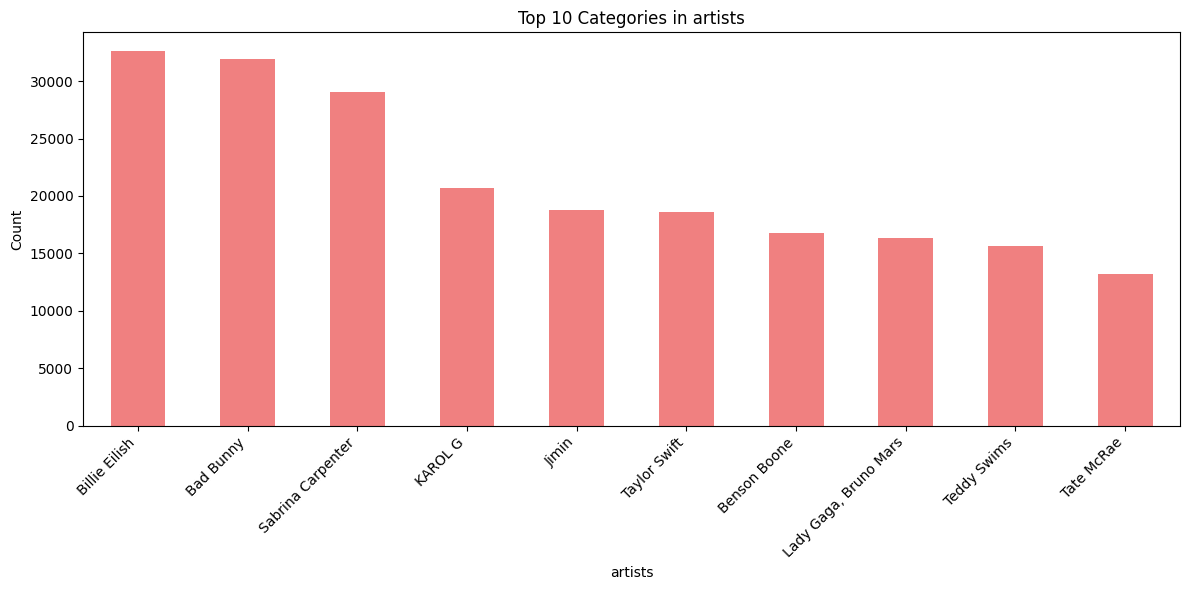


country - Value Counts:
country
Dominican Republic    58078
Italy                 29174
Nicaragua             29170
Poland                29164
Hungary               29163
Honduras              29162
El Salvador           29162
Thailand              29161
Czechia               29161
Egypt                 29161
Name: count, dtype: int64


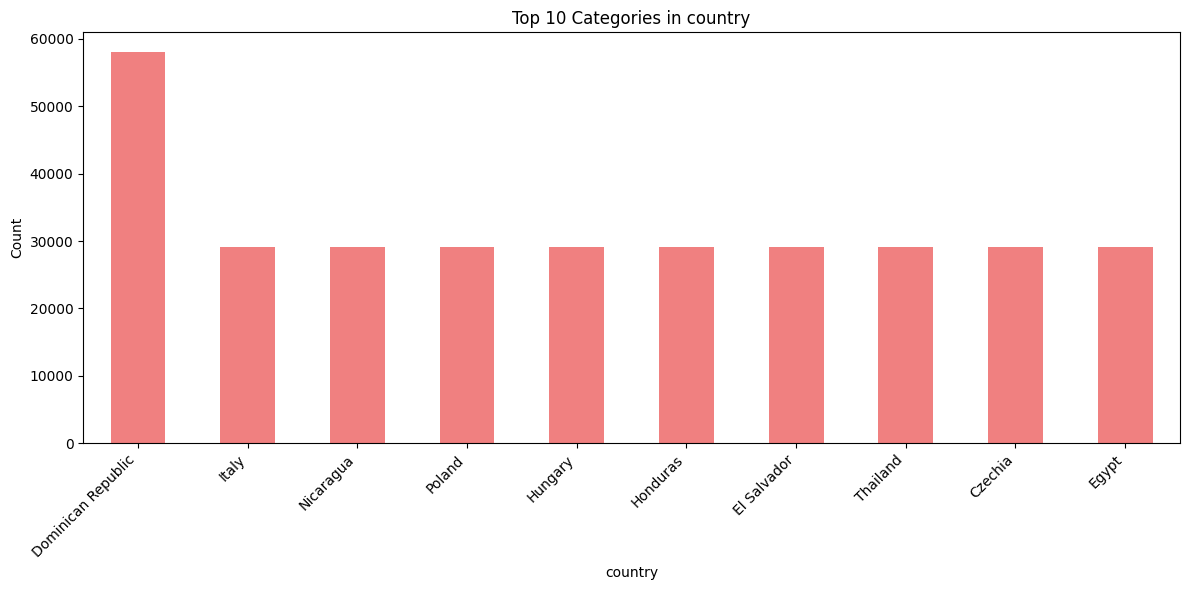


snapshot_date - Value Counts:
snapshot_date
2024-03-16    3942
2023-11-20    3866
2024-03-18    3836
2024-03-14    3769
2023-10-27    3766
2024-08-25    3650
2024-08-27    3650
2024-06-04    3650
2024-06-05    3650
2024-09-26    3650
Name: count, dtype: int64


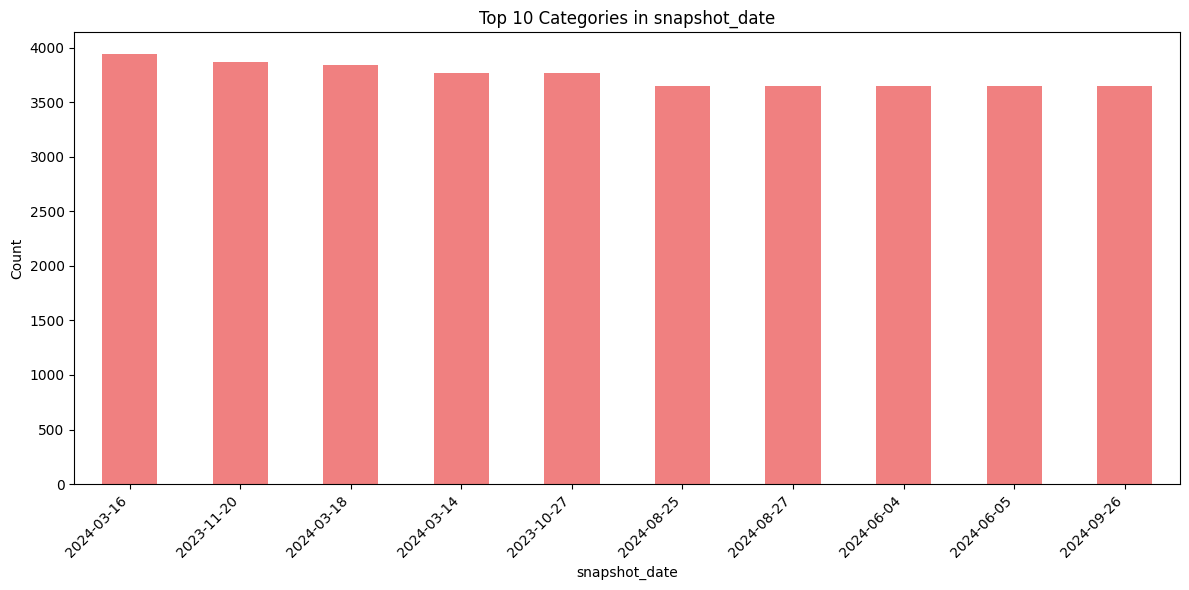


MISSING DATA VISUALIZATION:
   No missing data found!

EXPLORATORY DATA ANALYSIS - GENRES
BASIC STATISTICS:
          Unnamed: 0     popularity    duration_ms   danceability  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean    56999.500000      33.238526  222503.603719       0.567015   
std     32909.109681      22.305052   73137.454329       0.172915   
min         0.000000       0.000000   42906.000000       0.097500   
25%     28499.750000      17.000000  174066.000000       0.456000   
50%     56999.500000      35.000000  212906.000000       0.580000   
75%     85499.250000      50.000000  261506.000000       0.695000   
max    113999.000000      99.500000  392666.000000       0.985000   

              energy            key       loudness           mode  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.641383       5.309140      -7.942250       0.637553   
std         0.251529       3.559987       4.012136       0.480

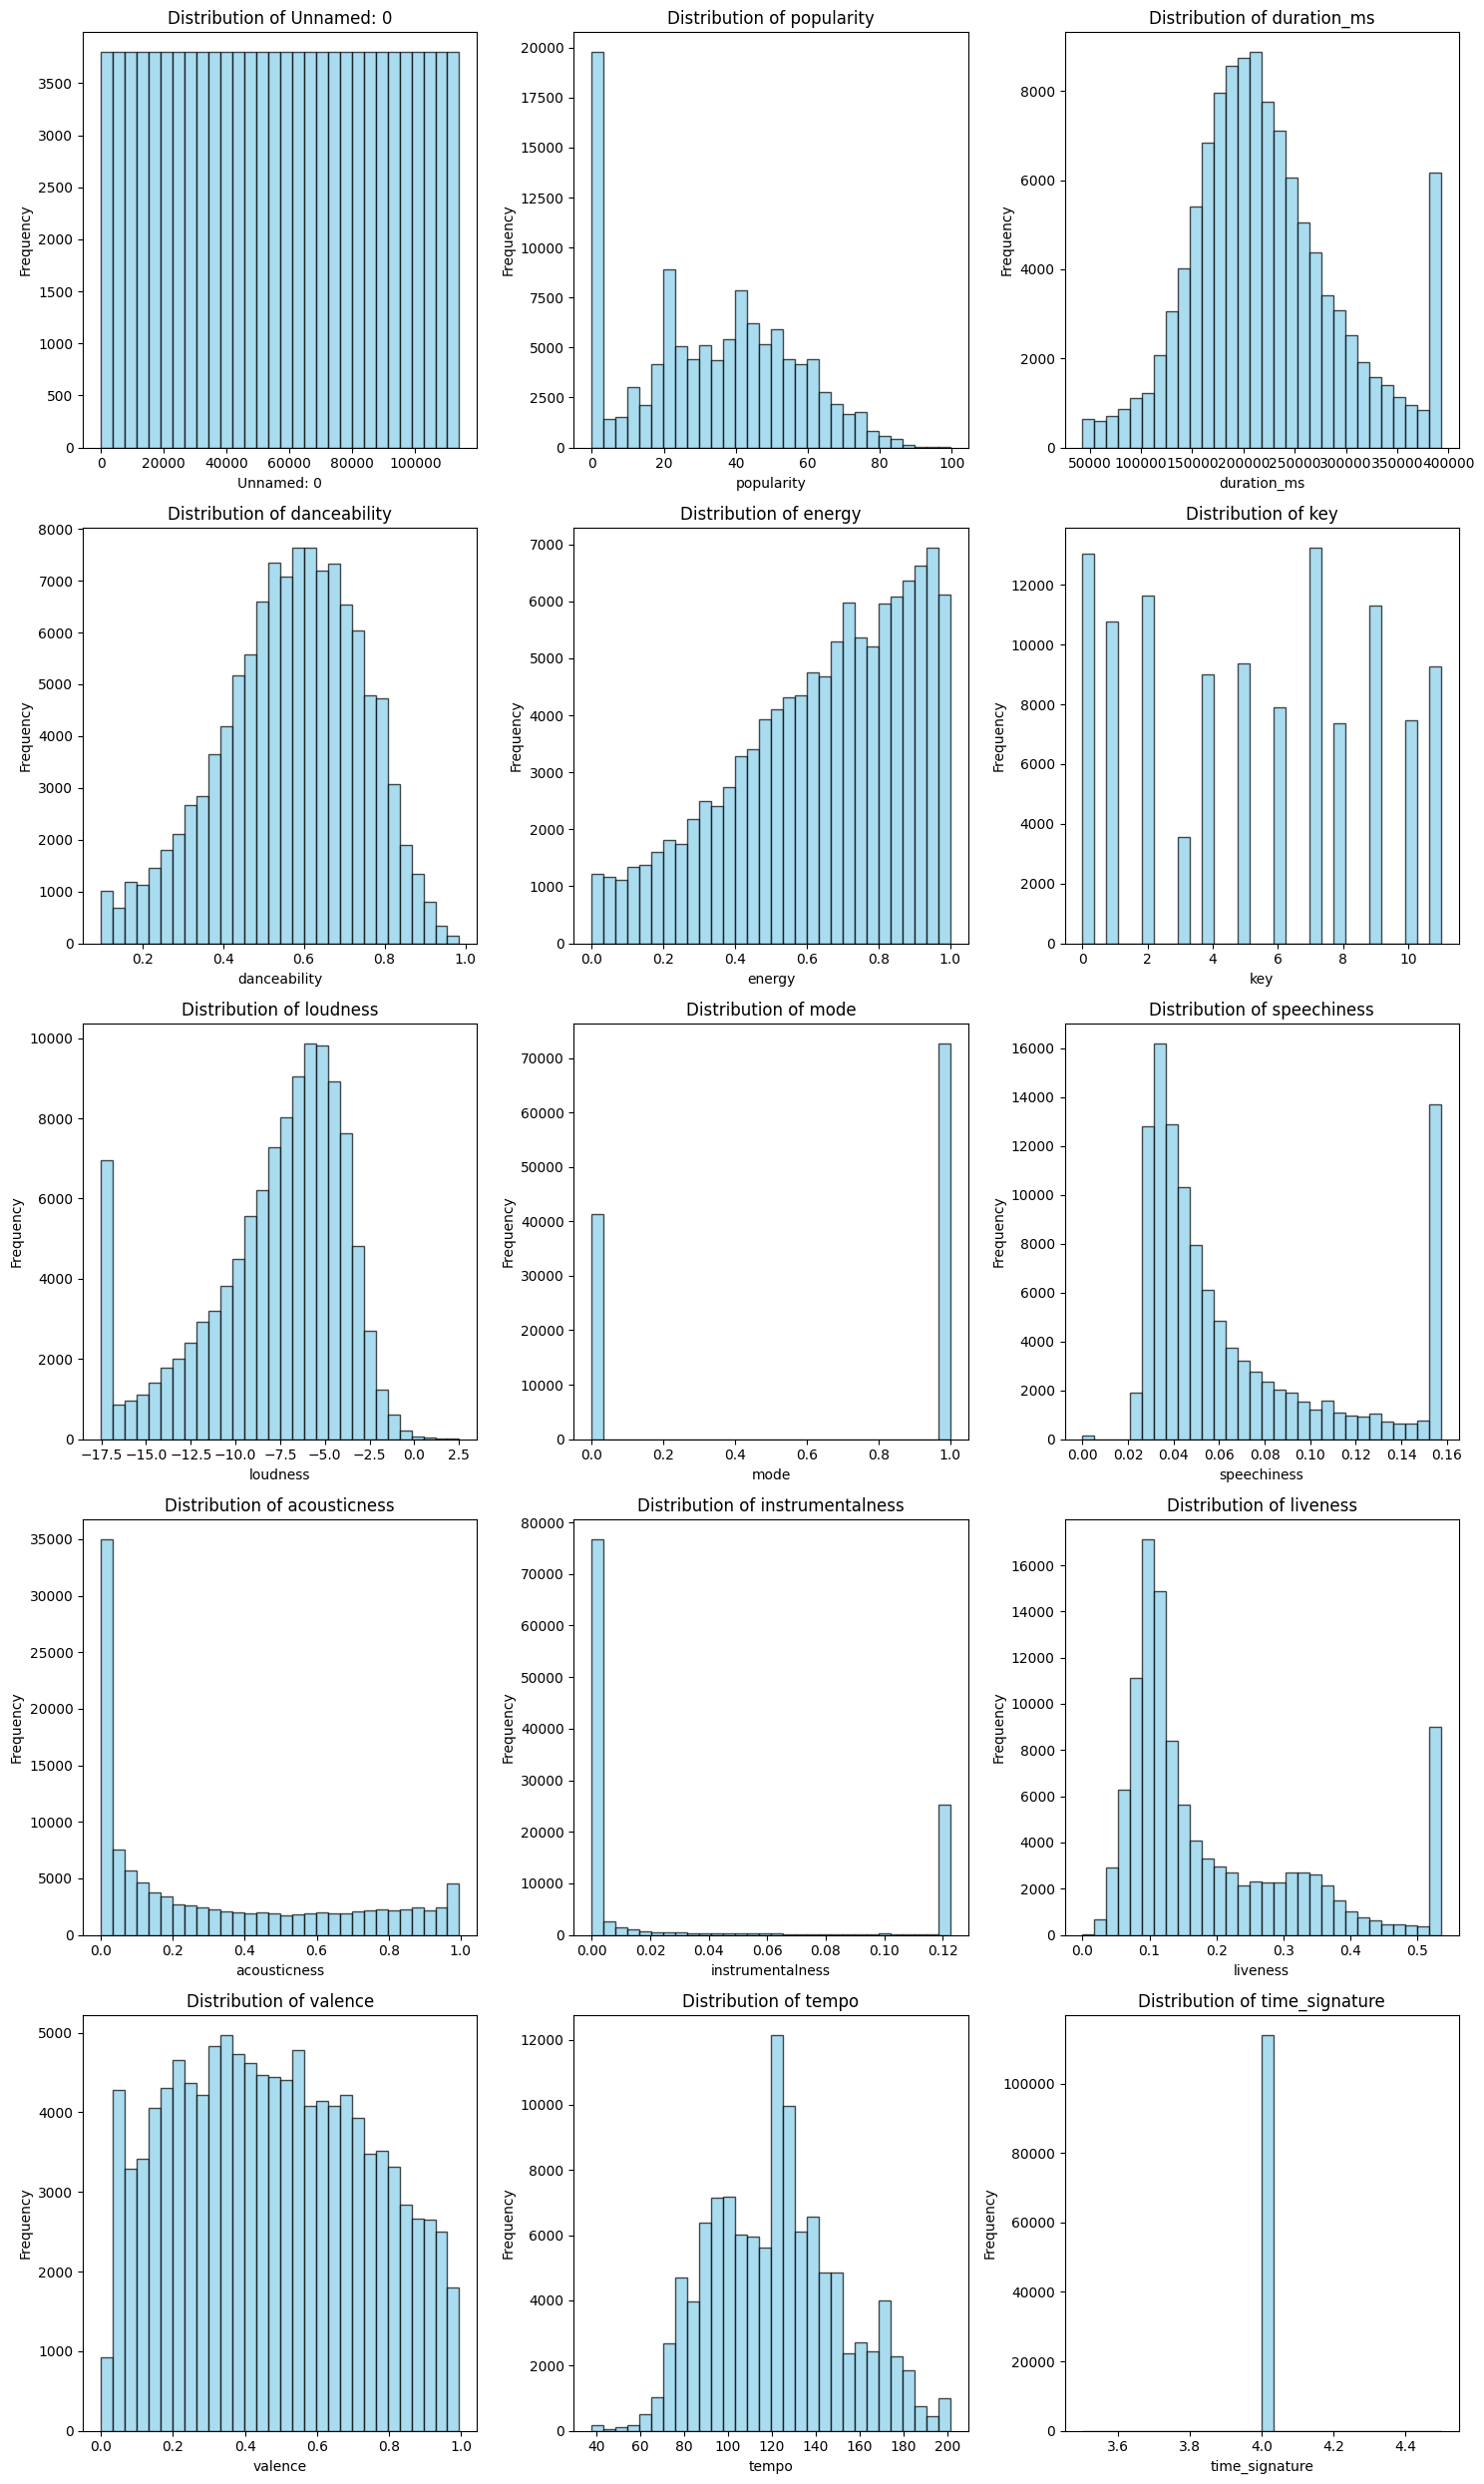


CORRELATION ANALYSIS:


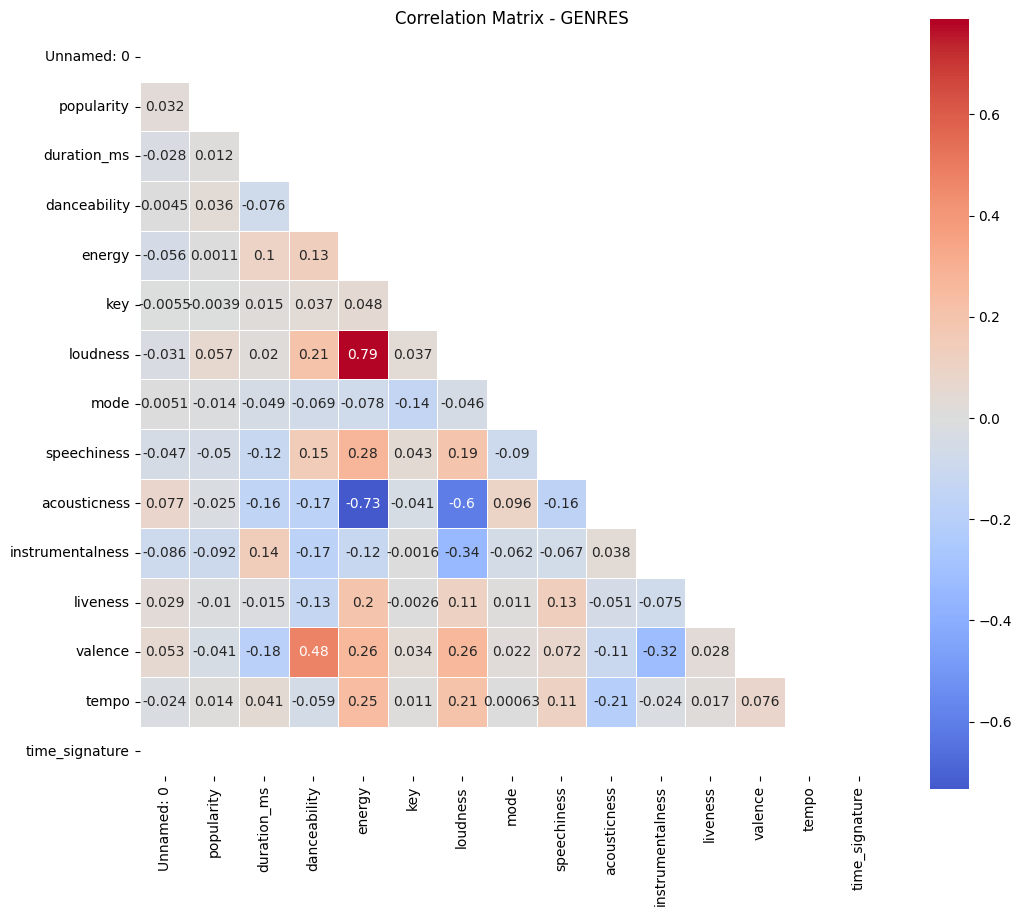

High correlation pairs (>0.7):
   energy - loudness: 0.788
   energy - acousticness: -0.734

CATEGORICAL DATA ANALYSIS:

track_id - Value Counts:
track_id
6S3JlDAGk3uu3NtZbPnuhS    9
2Ey6v4Sekh3Z0RUSISRosD    8
2kkvB3RNRzwjFdGhaUA0tz    8
4WJTKbNJQ41zXnb84jSWaj    7
2aaClnypAakdAmLw74JXxB    7
7tbzfR8ZvZzJEzy6v0d6el    7
5ZsAhuQ24mWHiduaxJqnhW    7
0YLSjVxSb5FT1Bo8Tnxr8j    7
2qgXrzJsry4KgYoJCpuaul    7
3dJjsWCy6ZwMfw5NbD226G    7
Name: count, dtype: int64


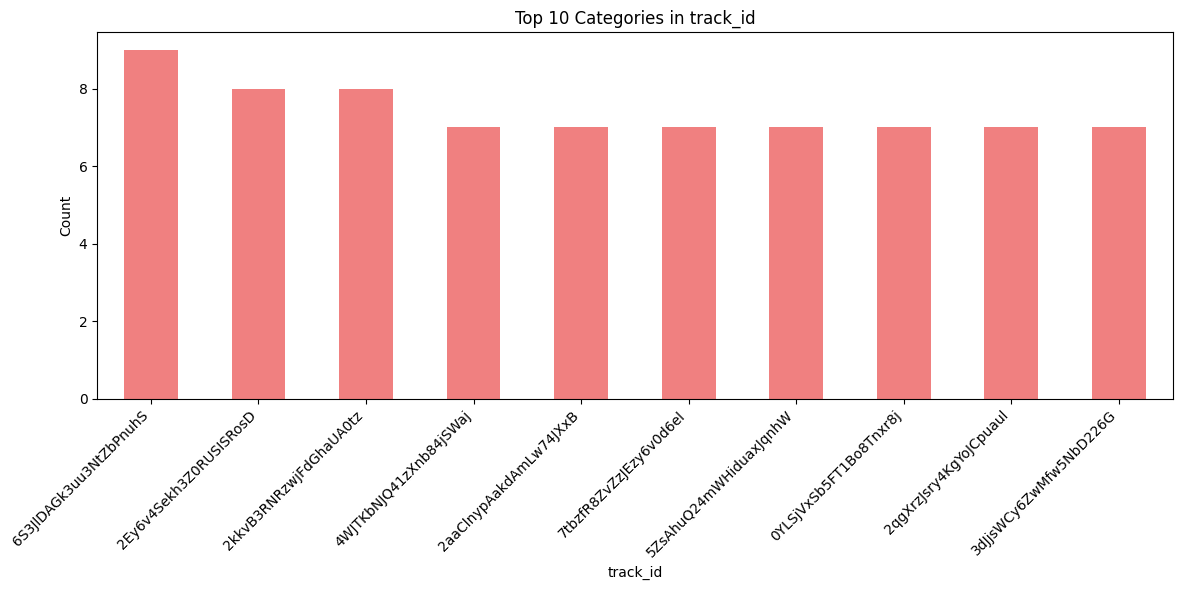


artists - Value Counts:
artists
The Beatles        280
George Jones       271
Stevie Wonder      236
Linkin Park        224
Ella Fitzgerald    222
Prateek Kuhad      217
Feid               202
Chuck Berry        190
Håkan Hellström    183
OneRepublic        181
Name: count, dtype: int64


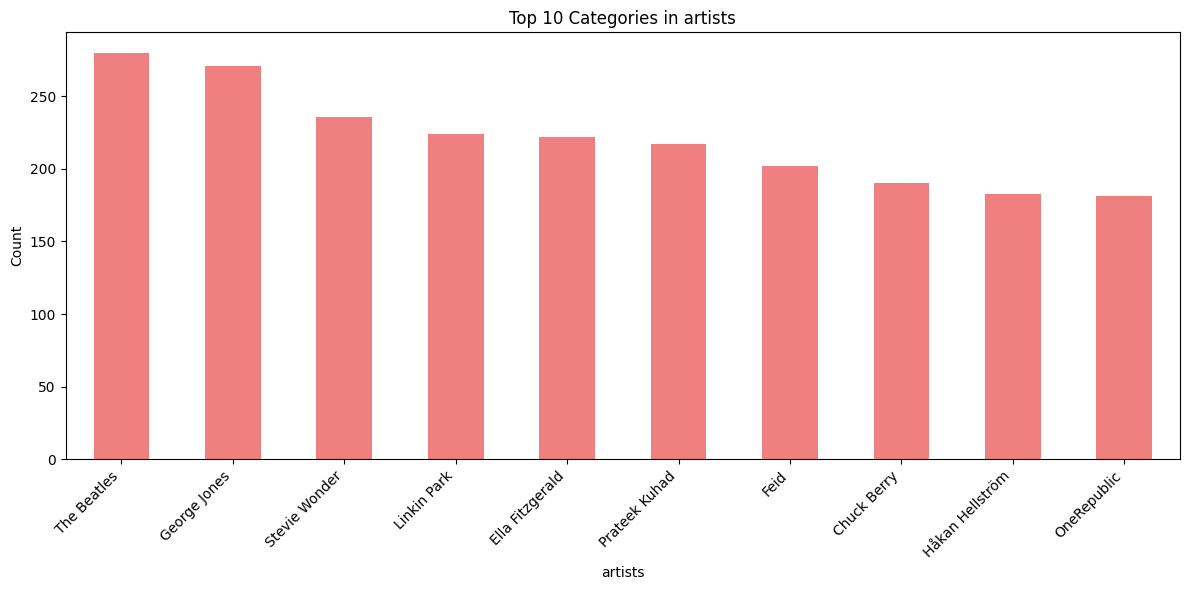


album_name - Value Counts:
album_name
Alternative Christmas 2022     196
Feliz Cumpleaños con Perreo    184
Metal                          143
Halloween con perreito         123
Halloween Party 2022           115
The Complete Hank Williams     111
Fiesta portatil                110
Frescura y Perreo              106
Esto me suena a Farra          105
Perreo en Halloween            103
Name: count, dtype: int64


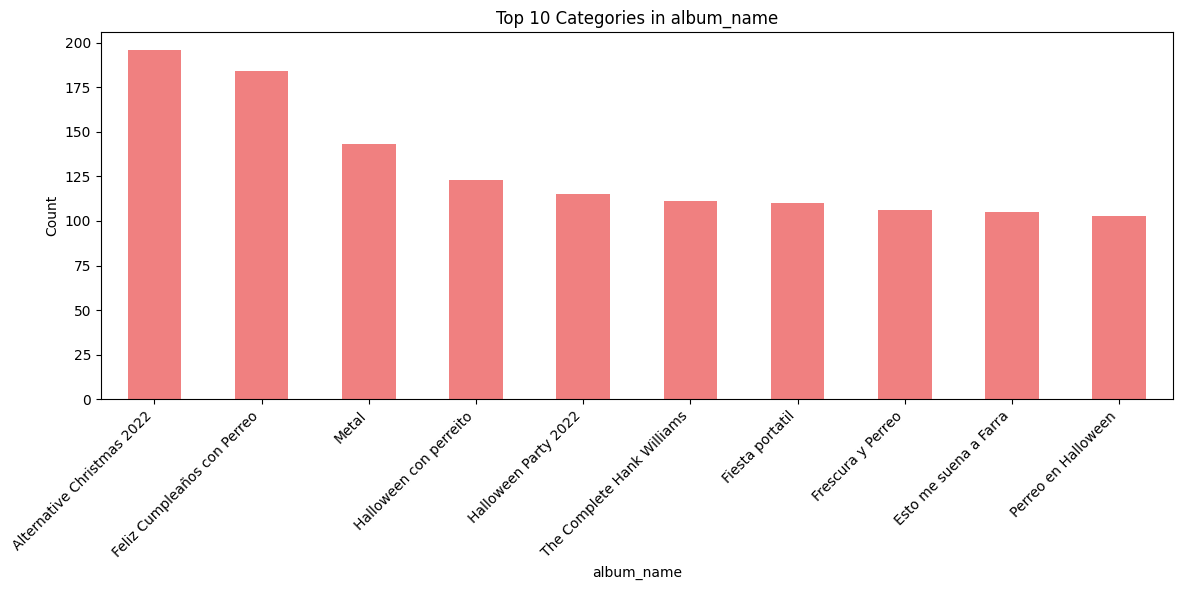


track_name - Value Counts:
track_name
Run Rudolph Run                   152
Halloween                          88
Frosty The Snowman                 81
Little Saint Nick - 1991 Remix     76
Last Last                          75
Christmas Time                     72
CÓMO SE SIENTE - Remix             64
Sleigh Ride                        61
RUMBATÓN                           60
X ÚLTIMA VEZ                       58
Name: count, dtype: int64


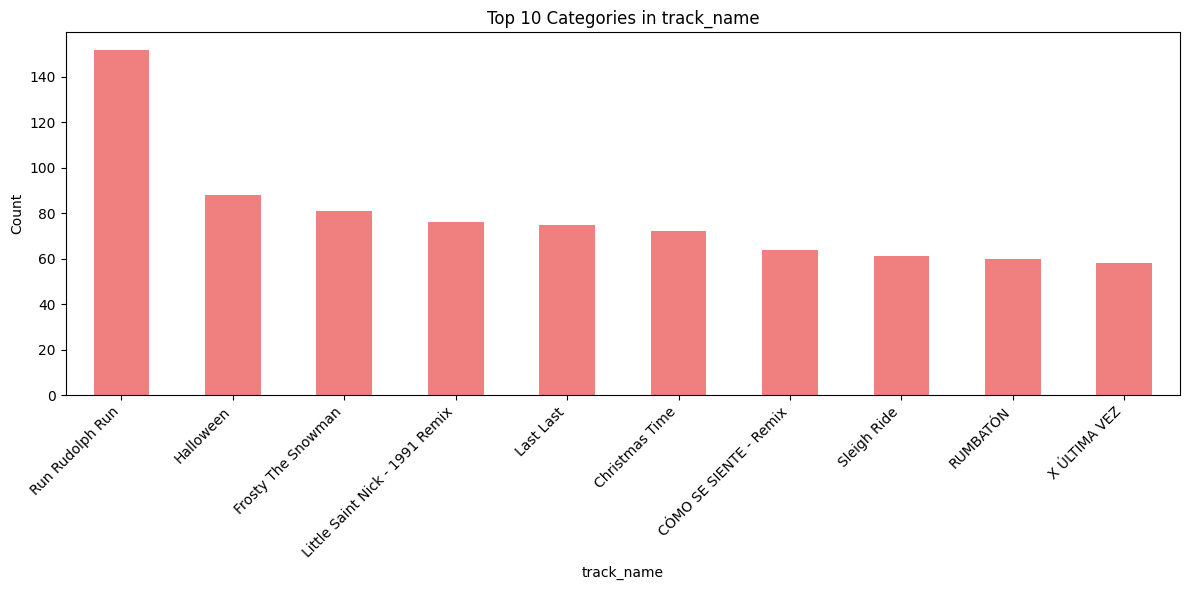


track_genre - Value Counts:
track_genre
acoustic       1000
afrobeat       1000
alt-rock       1000
alternative    1000
ambient        1000
anime          1000
black-metal    1000
bluegrass      1000
blues          1000
brazil         1000
Name: count, dtype: int64


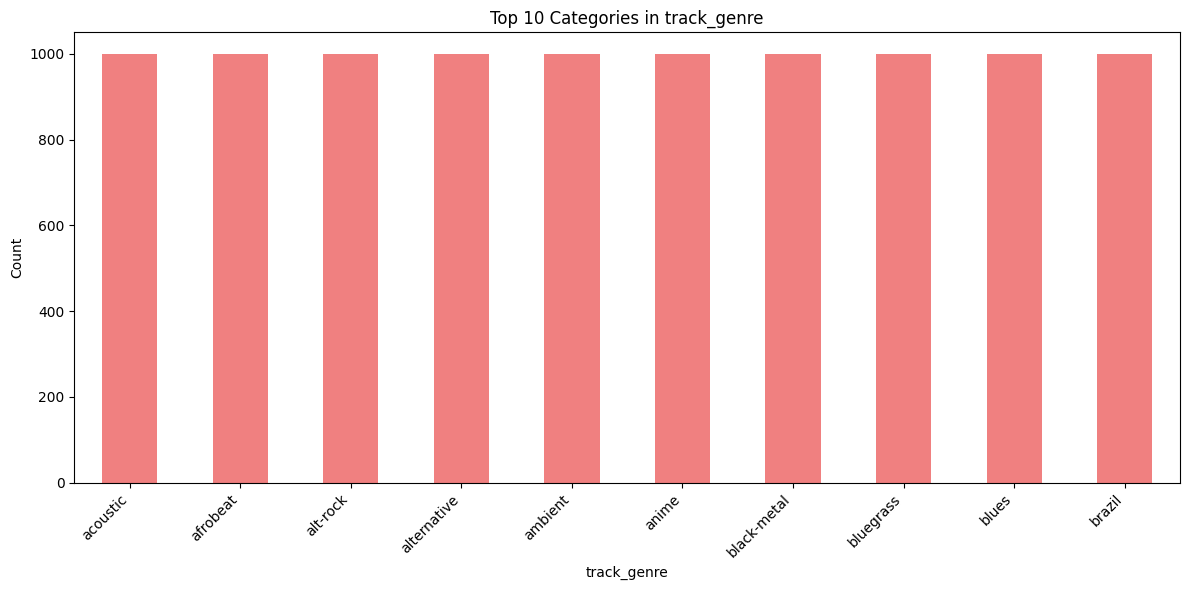


MISSING DATA VISUALIZATION:
   No missing data found!


In [ ]:
#EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_eda(df, dataset_name, save_plots=True):
    print(f"\nEXPLORATORY DATA ANALYSIS - {dataset_name}")
    print("=" * 60)

    # Basic Statistics
    print("BASIC STATISTICS:")
    print(df.describe())

    # Data Distribution Analysis
    print("\nDATA DISTRIBUTION ANALYSIS:")

    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    print(f"Numerical columns: {len(numerical_cols)}")
    print(f"Categorical columns: {len(categorical_cols)}")

    # Create subplots for distributions
    if len(numerical_cols) > 0:
        n_cols = 3
        n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

        for i, col in enumerate(numerical_cols):
            if i < len(axes):
                axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
                axes[i].set_title(f'Distribution of {col}')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Frequency')

        # Hide empty subplots
        for i in range(len(numerical_cols), len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        if save_plots:
            plt.savefig(f'{dataset_name}_distributions.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Correlation Analysis
    if len(numerical_cols) > 1:
        print("\nCORRELATION ANALYSIS:")
        correlation_matrix = df[numerical_cols].corr()

        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
                   center=0, square=True, linewidths=0.5)
        plt.title(f'Correlation Matrix - {dataset_name}')
        if save_plots:
            plt.savefig(f'{dataset_name}_correlation.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Find highly correlated pairs
        high_corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_value = correlation_matrix.iloc[i, j]
                if abs(corr_value) > 0.7:
                    high_corr_pairs.append((correlation_matrix.columns[i],
                                          correlation_matrix.columns[j],
                                          corr_value))

        if high_corr_pairs:
            print("High correlation pairs (>0.7):")
            for pair in high_corr_pairs:
                print(f"   {pair[0]} - {pair[1]}: {pair[2]:.3f}")

    # Categorical Data Analysis
    if len(categorical_cols) > 0:
        print("\nCATEGORICAL DATA ANALYSIS:")

        for col in categorical_cols[:5]:
            print(f"\n{col} - Value Counts:")
            value_counts = df[col].value_counts().head(10)
            print(value_counts)

            # Plot top categories
            plt.figure(figsize=(12, 6))
            value_counts.plot(kind='bar', color='lightcoral')
            plt.title(f'Top 10 Categories in {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            if save_plots:
                plt.savefig(f'{dataset_name}_{col}_categories.png', dpi=300, bbox_inches='tight')
            plt.show()

    # Missing Data Visualization
    print("\nMISSING DATA VISUALIZATION:")
    missing_data = df.isnull().sum()
    if missing_data.sum() > 0:
        plt.figure(figsize=(10, 6))
        missing_data[missing_data > 0].plot(kind='bar', color='orange')
        plt.title('Missing Data by Column')
        plt.xlabel('Columns')
        plt.ylabel('Missing Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        if save_plots:
            plt.savefig(f'{dataset_name}_missing_data.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("   No missing data found!")

    return {
        'numerical_cols': numerical_cols,
        'categorical_cols': categorical_cols,
        'correlation_matrix': correlation_matrix if len(numerical_cols) > 1 else None,
        'high_corr_pairs': high_corr_pairs if len(numerical_cols) > 1 else []
    }

# Perform EDA on both datasets
if df_countries_clean is not None:
    eda_countries = comprehensive_eda(df_countries_clean, "COUNTRIES")

if df_genres_clean is not None:
    eda_genres = comprehensive_eda(df_genres_clean, "GENRES")


 MUSIC-SPECIFIC EDA

 COUNTRY-WISE ANALYSIS:


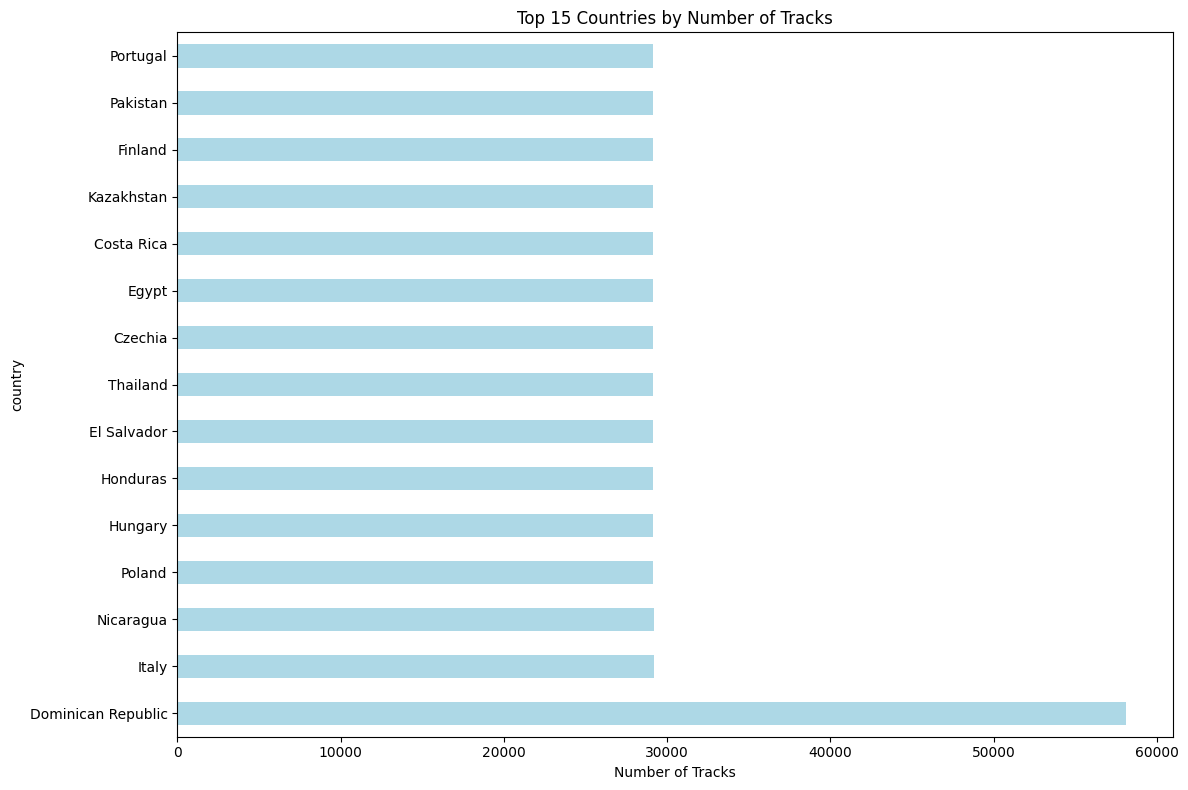

Date columns found: ['snapshot_date', 'album_release_date']

🎼 GENRE-WISE ANALYSIS:


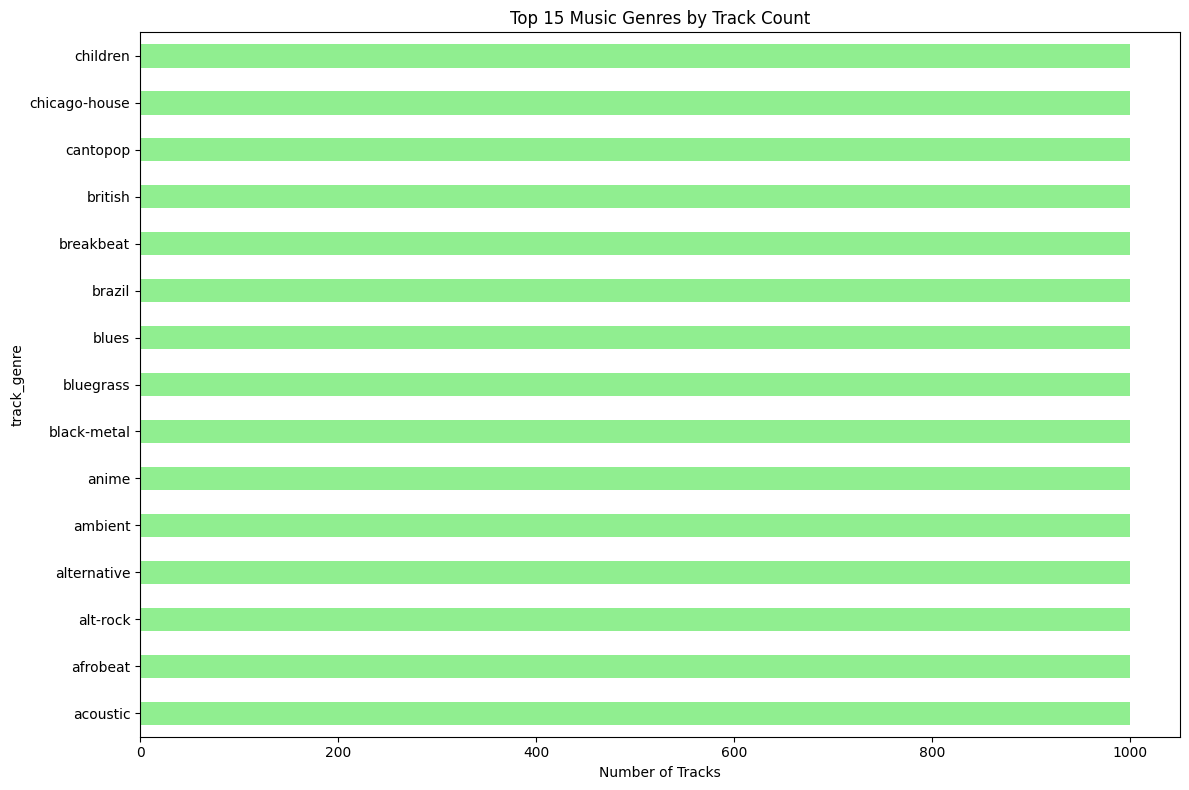

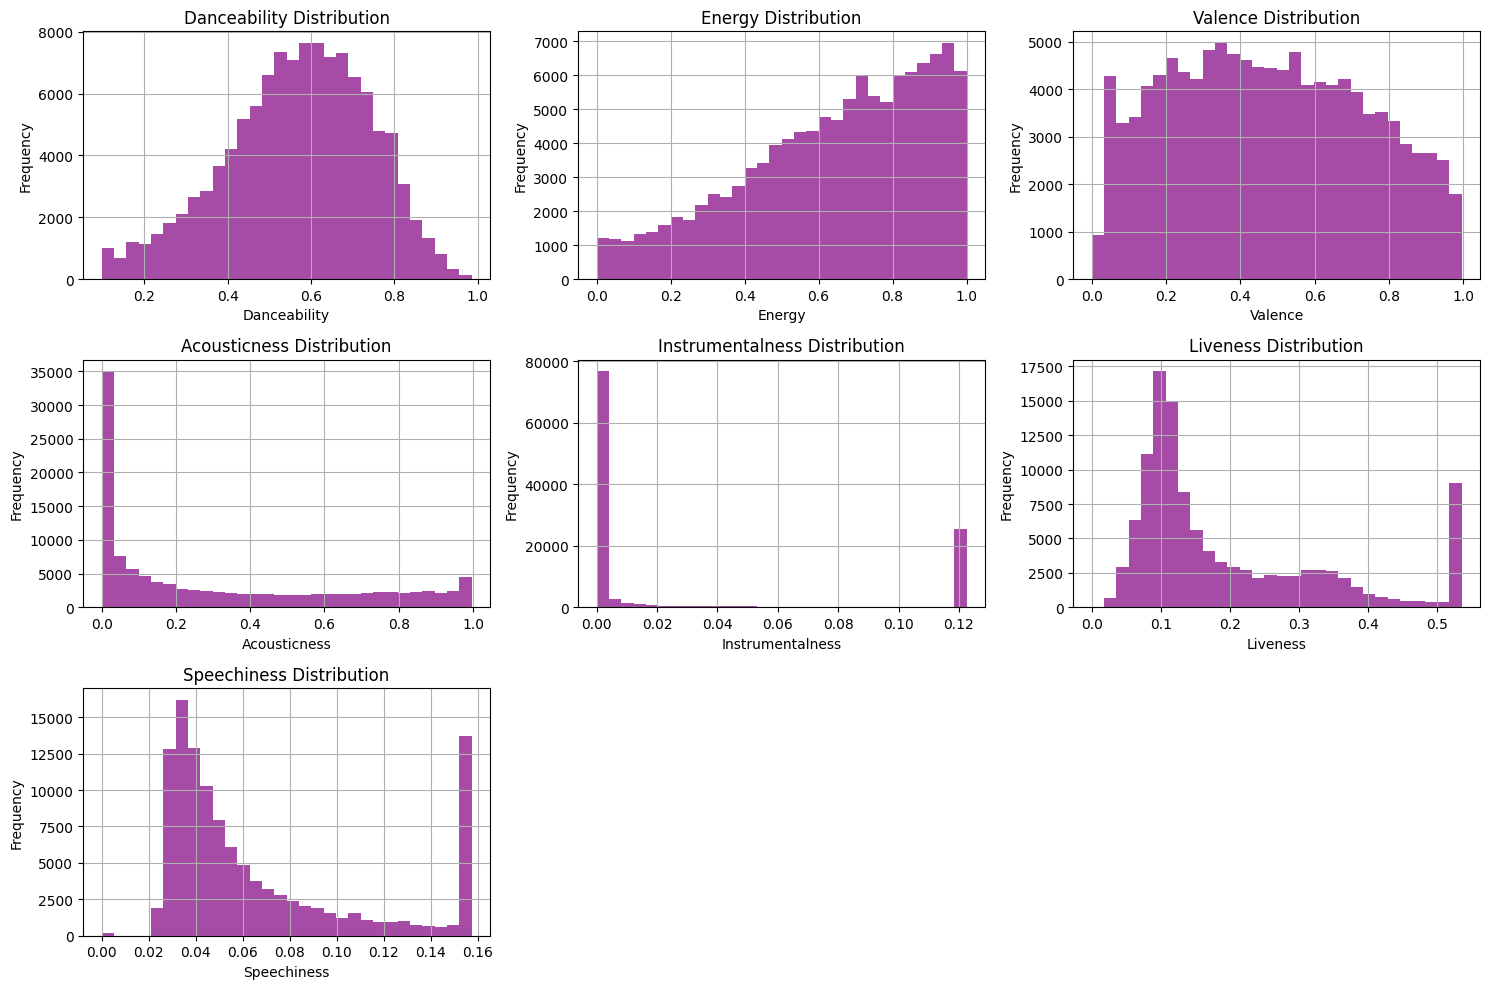

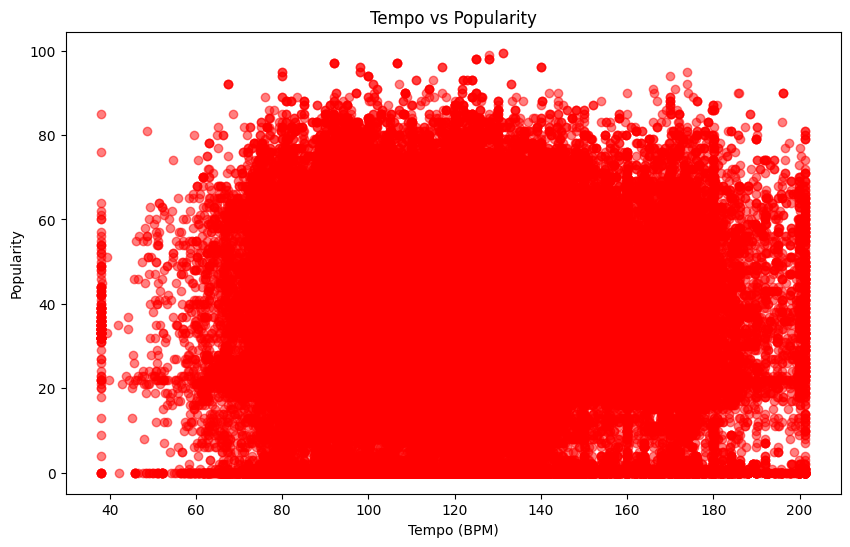

In [ ]:
# Music-Specific EDA Functions


def music_specific_eda(df_countries, df_genres):
    """
    Music-specific exploratory analysis
    """
    print("\n MUSIC-SPECIFIC EDA")
    print("=" * 50)

    # Analysis for Countries Dataset
    if df_countries is not None:
        print("\n COUNTRY-WISE ANALYSIS:")

        # Top countries by number of tracks
        if 'country' in df_countries.columns:
            country_counts = df_countries['country'].value_counts().head(15)

            plt.figure(figsize=(12, 8))
            country_counts.plot(kind='barh', color='lightblue')
            plt.title('Top 15 Countries by Number of Tracks')
            plt.xlabel('Number of Tracks')
            plt.tight_layout()
            plt.show()

        # Daily trends if date column exists
        date_columns = [col for col in df_countries.columns if 'date' in col.lower()]
        if date_columns:
            print(f"Date columns found: {date_columns}")

    # Analysis for Genres Dataset
    if df_genres is not None:
        print("\n🎼 GENRE-WISE ANALYSIS:")

        # Genre distribution
        if 'track_genre' in df_genres.columns:
            genre_counts = df_genres['track_genre'].value_counts().head(15)

            plt.figure(figsize=(12, 8))
            genre_counts.plot(kind='barh', color='lightgreen')
            plt.title('Top 15 Music Genres by Track Count')
            plt.xlabel('Number of Tracks')
            plt.tight_layout()
            plt.show()

        # Audio features analysis
        audio_features = ['danceability', 'energy', 'valence', 'acousticness',
                         'instrumentalness', 'liveness', 'speechiness']

        available_features = [col for col in audio_features if col in df_genres.columns]

        if available_features:
            plt.figure(figsize=(15, 10))
            for i, feature in enumerate(available_features, 1):
                plt.subplot(3, 3, i)
                df_genres[feature].hist(bins=30, alpha=0.7, color='purple')
                plt.title(f'{feature.capitalize()} Distribution')
                plt.xlabel(feature.capitalize())
                plt.ylabel('Frequency')

            plt.tight_layout()
            plt.show()

        # Tempo vs Popularity analysis
        if 'tempo' in df_genres.columns and 'popularity' in df_genres.columns:
            plt.figure(figsize=(10, 6))
            plt.scatter(df_genres['tempo'], df_genres['popularity'], alpha=0.5, color='red')
            plt.xlabel('Tempo (BPM)')
            plt.ylabel('Popularity')
            plt.title('Tempo vs Popularity')
            plt.show()

# Run music-specific EDA
if df_countries is not None and df_genres is not None:
    music_specific_eda(df_countries_clean, df_genres_clean)



In [ ]:
# Data Quality Report


def generate_data_quality_report(df_countries, df_genres):
    """
    Generate comprehensive data quality report
    """
    print("\n DATA QUALITY REPORT")
    print("=" * 60)

    def analyze_dataset(df, name):
        print(f"\n{name} DATASET:")
        print(f"   Shape: {df.shape}")
        print(f"   Numerical columns: {len(df.select_dtypes(include=[np.number]).columns)}")
        print(f"   Categorical columns: {len(df.select_dtypes(include=['object']).columns)}")
        print(f"   Missing values: {df.isnull().sum().sum()}")
        print(f"   Duplicates: {df.duplicated().sum()}")
        print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        return {
            'shape': df.shape,
            'numerical_cols': len(df.select_dtypes(include=[np.number]).columns),
            'categorical_cols': len(df.select_dtypes(include=['object']).columns),
            'missing_values': df.isnull().sum().sum(),
            'duplicates': df.duplicated().sum(),
            'memory_mb': df.memory_usage(deep=True).sum() / 1024**2
        }

    # Analyze both datasets
    countries_report = analyze_dataset(df_countries, "COUNTRIES") if df_countries is not None else None
    genres_report = analyze_dataset(df_genres, "GENRES") if df_genres is not None else None

    # Combined statistics
    if countries_report and genres_report:
        print(f"\n COMBINED STATISTICS:")
        print(f"  Total records: {countries_report['shape'][0] + genres_report['shape'][0]:,}")
        print(f"  Total features: {countries_report['shape'][1] + genres_report['shape'][1]}")
        print(f"  Combined memory: {countries_report['memory_mb'] + genres_report['memory_mb']:.2f} MB")

    return countries_report, genres_report

# Generate final report
countries_report, genres_report = generate_data_quality_report(
    df_countries_clean if df_countries is not None else None,
    df_genres_clean if df_genres is not None else None
)

print("\n DATA COLLECTION, CLEANING, AND EDA COMPLETED!")



 DATA QUALITY REPORT

COUNTRIES DATASET:
   Shape: (2110310, 25)
   Numerical columns: 17
   Categorical columns: 7
   Missing values: 0
   Duplicates: 0
   Memory usage: 1341.72 MB

GENRES DATASET:
   Shape: (114000, 21)
   Numerical columns: 15
   Categorical columns: 5
   Missing values: 0
   Duplicates: 0
   Memory usage: 55.29 MB

 COMBINED STATISTICS:
  Total records: 2,224,310
  Total features: 46
  Combined memory: 1397.01 MB

 DATA COLLECTION, CLEANING, AND EDA COMPLETED!


 STEP 4: DATA TRANSFORMATION AND FEATURE ENGINEERING
Starting Optimized Feature Engineering Process...

 EXECUTING FEATURE ENGINEERING PIPELINE

 PROCESSING COUNTRIES DATASET:
🎵 NORMALIZING AUDIO FEATURES:
  danceability: [0.280, 0.988] → [0, 1]
  energy: [0.230, 0.998] → [0, 1]
  valence: [0.000, 0.992] → [0, 1]
  acousticness: [0.000, 0.992] → [0, 1]

 STANDARDIZING NUMERICAL FEATURES:
    daily_rank: μ=25.493, σ=14.429 → μ=0, σ=1
    daily_movement: μ=0.283, σ=3.191 → μ=0, σ=1
    weekly_movement: μ=1.494, σ=8.088 → μ=0, σ=1
    popularity: μ=76.108, σ=14.988 → μ=0, σ=1
    duration_ms: μ=192778.576, σ=43637.916 → μ=0, σ=1

 ENCODING CATEGORICAL FEATURES (ONEHOT):
   spotify_id: Label encoded (24983 categories)
   name: Label encoded (21809 categories)
   artists: Label encoded (13726 categories)

 CREATING COUNTRY-SPECIFIC FEATURES:
   Added tracks_per_country
    Added regional grouping
   Added date-based features from snapshot_date
    Countries dataset transformed: (2110310, 42

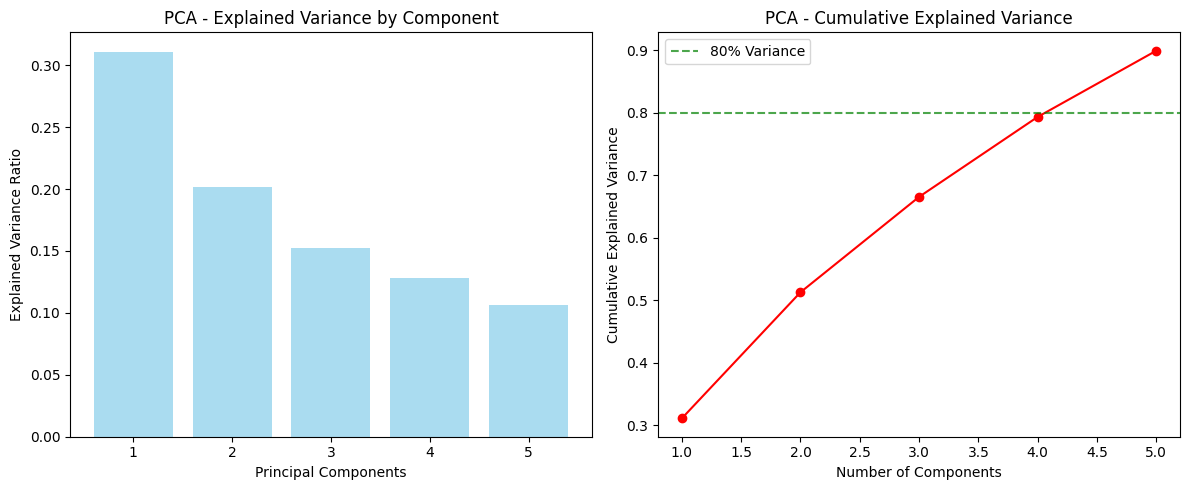


 CREATING INTERACTION FEATURES:
    Created interactions for danceability and energy
    Created interactions for valence and energy
    Created interactions for acousticness and instrumentalness
    Created interactions for popularity and danceability
    Genres dataset transformed: (114000, 76)

 FEATURE ENGINEERING COMPLETED SUCCESSFULLY!

 FINAL COUNTRIES DATASET:
   Shape: (2110310, 42)
   New features created: 17
   Memory usage: 1697.83 MB

 FINAL GENRES DATASET:
   Shape: (114000, 76)
   New features created: 55
   Memory usage: 97.47 MB

🎯 TOP 10 FEATURES CORRELATED WITH POPULARITY:
popularity                     1.000000
popularity_standardized        1.000000
popularity_x_danceability      0.897489
popularity_div_danceability    0.723556
popularity_mean                0.504154
audio_complexity               0.096411
instrumentalness               0.092107
instrumentalness_normalized    0.092107
pca_component_5                0.068525
pca_component_4                0.066109


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from functools import lru_cache
import warnings
warnings.filterwarnings('ignore')

print(" STEP 4: DATA TRANSFORMATION AND FEATURE ENGINEERING")
print("=" * 70)

class OptimizedMusicDataTransformer:
    """
    Optimized data transformation class for music data with improved performance
    """

    def __init__(self):
        self.scalers = {}
        self.encoders = {}
        self.feature_stats = {}
        self._cached_stats = {}

    def _get_available_features(self, df, feature_list):
        """Helper method to get available features from list"""
        return [f for f in feature_list if f in df.columns]

    def _calculate_stats(self, series, feature_name):
        """Calculate and cache statistics for a feature"""
        if feature_name not in self._cached_stats:
            self._cached_stats[feature_name] = {
                'min': series.min(),
                'max': series.max(),
                'mean': series.mean(),
                'std': series.std()
            }
        return self._cached_stats[feature_name]

    def normalize_audio_features(self, df, audio_features):
        """
        Vectorized normalization of audio features to 0-1 range
        """
        print("🎵 NORMALIZING AUDIO FEATURES:")

        available_features = self._get_available_features(df, audio_features)
        if not available_features:
            return df

        # Vectorized normalization using pandas
        df_normalized = df.copy()

        for feature in available_features:
            stats = self._calculate_stats(df[feature], feature)
            self.feature_stats[feature] = {
                'original_min': stats['min'],
                'original_max': stats['max'],
                'original_mean': stats['mean'],
                'original_std': stats['std']
            }

            # Vectorized normalization
            feature_range = stats['max'] - stats['min']
            if feature_range > 0:
                df_normalized[f'{feature}_normalized'] = (df[feature] - stats['min']) / feature_range
            else:
                df_normalized[f'{feature}_normalized'] = 0

            print(f"  {feature}: [{stats['min']:.3f}, {stats['max']:.3f}] → [0, 1]")

        return df_normalized

    def standardize_features(self, df, numerical_features):
        """
        Vectorized standardization of numerical features
        """
        print("\n STANDARDIZING NUMERICAL FEATURES:")

        available_features = self._get_available_features(df, numerical_features)
        if not available_features:
            return df

        df_standardized = df.copy()

        # Batch standardization using pandas
        for feature in available_features:
            stats = self._calculate_stats(df[feature], feature)

            if stats['std'] > 0:
                df_standardized[f'{feature}_standardized'] = (df[feature] - stats['mean']) / stats['std']
            else:
                df_standardized[f'{feature}_standardized'] = 0

            print(f"    {feature}: μ={stats['mean']:.3f}, σ={stats['std']:.3f} → μ=0, σ=1")

        return df_standardized

    def encode_categorical_features(self, df, categorical_features, method='onehot'):
        """
        Optimized categorical encoding with memory management
        """
        print(f"\n ENCODING CATEGORICAL FEATURES ({method.upper()}):")

        available_features = self._get_available_features(df, categorical_features)
        if not available_features:
            return df

        df_encoded = df.copy()

        for feature in available_features:
            unique_values = df[feature].nunique()

            if method == 'onehot' and unique_values <= 50:
                # Use pandas get_dummies for better performance
                encoded_cols = pd.get_dummies(df[feature], prefix=feature, dtype=np.int8)
                df_encoded = pd.concat([df_encoded, encoded_cols], axis=1)
                print(f"   {feature}: One-hot encoded ({unique_values} categories)")

            elif method == 'label' or unique_values > 50:
                le = LabelEncoder()
                df_encoded[f'{feature}_encoded'] = le.fit_transform(df[feature].astype(str))
                self.encoders[feature] = le
                print(f"   {feature}: Label encoded ({unique_values} categories)")

        return df_encoded

    def create_music_features(self, df):
        """
        Optimized music feature creation with vectorized operations
        """
        print("\n CREATING MUSIC-SPECIFIC FEATURES:")

        # Pre-allocate dictionary for new features
        new_features = {}

        # 1. Audio Feature Combinations (vectorized)
        if all(col in df.columns for col in ['danceability', 'energy']):
            new_features['dance_energy_ratio'] = df['danceability'] / (df['energy'] + 0.001)
            new_features['party_score'] = (df['danceability'] + df['energy']) * 0.5
            print("    Created dance_energy_ratio and party_score")

        if all(col in df.columns for col in ['valence', 'energy']):
            new_features['mood_energy_score'] = df['valence'] * df['energy']
            print("    Created mood_energy_score")

        if all(col in df.columns for col in ['acousticness', 'instrumentalness']):
            new_features['acoustic_instrumental_blend'] = (df['acousticness'] + df['instrumentalness']) * 0.5
            print("    Created acoustic_instrumental_blend")

        # 2. Optimized binning operations
        if 'tempo' in df.columns:
            new_features['tempo_category'] = pd.cut(df['tempo'],
                                                   bins=[0, 80, 120, 140, 200],
                                                   labels=['Slow', 'Moderate', 'Fast', 'Very Fast'])
            print("    Created tempo_category")

        if 'popularity' in df.columns:
            new_features['popularity_tier'] = pd.cut(df['popularity'],
                                                    bins=[0, 25, 50, 75, 100],
                                                    labels=['Low', 'Medium', 'High', 'Very High'])
            print("    Created popularity_tier")

        if 'duration_ms' in df.columns:
            new_features['duration_minutes'] = df['duration_ms'] / 60000
            new_features['duration_category'] = pd.cut(new_features['duration_minutes'],
                                                      bins=[0, 2, 3.5, 5, 20],
                                                      labels=['Short', 'Medium', 'Long', 'Very Long'])
            print("    Created duration_minutes and duration_category")

        # 3. Vectorized composite scores
        audio_features = ['danceability', 'energy', 'speechiness', 'acousticness',
                         'instrumentalness', 'liveness', 'valence']
        available_audio_features = self._get_available_features(df, audio_features)

        if len(available_audio_features) >= 3:
            audio_subset = df[available_audio_features]
            new_features['audio_complexity'] = audio_subset.std(axis=1)

            # Optimized weighted score calculation
            if 'popularity' in df.columns:
                weights = {'danceability': 0.3, 'energy': 0.25, 'valence': 0.2,
                          'acousticness': 0.1, 'instrumentalness': 0.15}

                weighted_score = pd.Series(0, index=df.index)
                total_weight = 0

                for feature, weight in weights.items():
                    if feature in df.columns:
                        weighted_score += df[feature] * weight
                        total_weight += weight

                if total_weight > 0:
                    new_features['audio_weighted_score'] = weighted_score / total_weight
                    print("    Created audio_complexity and audio_weighted_score")

        # Efficiently concatenate all new features
        if new_features:
            new_df = pd.DataFrame(new_features, index=df.index)
            return pd.concat([df, new_df], axis=1)

        return df

def create_country_specific_features(df_countries):
    """
    Optimized country-specific feature creation
    """
    print("\n CREATING COUNTRY-SPECIFIC FEATURES:")

    if df_countries is None:
        return None

    df_country_featured = df_countries.copy()

    # 1. Optimized country statistics using groupby
    if 'country' in df_countries.columns:
        country_stats = df_countries.groupby('country').size().rename('tracks_per_country')
        df_country_featured = df_country_featured.merge(
            country_stats, left_on='country', right_index=True, how='left'
        )
        print("   Added tracks_per_country")

    # 2. Vectorized regional mapping
    region_mapping = {
        'United States': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
        'United Kingdom': 'Europe', 'Germany': 'Europe', 'France': 'Europe', 'Spain': 'Europe',
        'Italy': 'Europe', 'Netherlands': 'Europe', 'Sweden': 'Europe', 'Norway': 'Europe',
        'Brazil': 'South America', 'Argentina': 'South America', 'Chile': 'South America',
        'India': 'Asia', 'Japan': 'Asia', 'South Korea': 'Asia', 'China': 'Asia',
        'Australia': 'Oceania', 'New Zealand': 'Oceania'
    }

    if 'country' in df_countries.columns:
        df_country_featured['region'] = df_country_featured['country'].map(region_mapping).fillna('Other')
        print("    Added regional grouping")

    # 3. Optimized date processing
    date_columns = [col for col in df_countries.columns if 'date' in col.lower()]
    if date_columns:
        date_col = date_columns[0]
        try:
            dates = pd.to_datetime(df_country_featured[date_col])
            df_country_featured[date_col] = dates
            df_country_featured['day_of_week'] = dates.dt.day_name()
            df_country_featured['month'] = dates.dt.month
            df_country_featured['is_weekend'] = dates.dt.weekday >= 5
            print(f"   Added date-based features from {date_col}")
        except:
            print(f"   Could not parse date column: {date_col}")

    return df_country_featured

def create_genre_specific_features(df_genres):
    """
    Optimized genre-specific feature creation
    """
    print("\n🎵 CREATING GENRE-SPECIFIC FEATURES:")

    if df_genres is None:
        return None

    df_genre_featured = df_genres.copy()

    # 1. Optimized genre statistics with single groupby
    if 'track_genre' in df_genres.columns:
        numeric_cols = ['popularity', 'tempo', 'danceability', 'energy']
        available_cols = [col for col in numeric_cols if col in df_genres.columns]

        if available_cols:
            genre_stats = df_genres.groupby('track_genre')[available_cols].agg(['mean', 'std', 'count']).round(3)
            genre_stats.columns = ['_'.join(col) for col in genre_stats.columns]

            df_genre_featured = df_genre_featured.merge(
                genre_stats, left_on='track_genre', right_index=True, how='left'
            )
            print("    Added genre-level statistics")

    # 2. Vectorized artist features
    if 'artists' in df_genres.columns:
        df_genre_featured['num_artists'] = df_genre_featured['artists'].str.count(',') + 1
        df_genre_featured['is_collaboration'] = (df_genre_featured['num_artists'] > 1).astype(np.int8)
        print("    Added artist collaboration features")

    # 3. Optimized clustering
    audio_features = ['danceability', 'energy', 'speechiness', 'acousticness',
                     'instrumentalness', 'liveness', 'valence']
    available_features = [f for f in audio_features if f in df_genres.columns]

    if len(available_features) >= 4:
        cluster_data = df_genres[available_features].fillna(0)
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        df_genre_featured['audio_cluster'] = kmeans.fit_predict(cluster_data)
        print("    Added audio feature clustering")

    return df_genre_featured

def perform_dimensionality_reduction(df, numerical_features, n_components=5):
    """
    Optimized PCA with better memory management
    """
    print(f"\n DIMENSIONALITY REDUCTION (PCA - {n_components} components):")

    available_features = [f for f in numerical_features if f in df.columns]

    if len(available_features) < 3:
        print("    Not enough numerical features for PCA")
        return df, None

    # Efficient data preparation
    pca_data = df[available_features].fillna(0)

    # Use float32 for memory efficiency
    scaler = StandardScaler()
    pca_data_scaled = scaler.fit_transform(pca_data.astype(np.float32))

    # Apply PCA
    n_comp = min(n_components, len(available_features))
    pca = PCA(n_components=n_comp, random_state=42)
    pca_result = pca.fit_transform(pca_data_scaled)

    # Efficiently add PCA components
    pca_df = pd.DataFrame(
        pca_result,
        columns=[f'pca_component_{i+1}' for i in range(n_comp)],
        index=df.index
    )

    df_pca = pd.concat([df, pca_df], axis=1)

    # Print results
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    print("   PCA Results:")
    for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
        print(f"      PC{i+1}: {var:.3f} variance, {cum_var:.3f} cumulative")

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, color='skyblue')
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('PCA - Explained Variance by Component')

    ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'bo-', color='red')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance')
    ax2.set_title('PCA - Cumulative Explained Variance')
    ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='80% Variance')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return df_pca, pca

def create_interaction_features(df, feature_pairs):
    """
    Vectorized interaction feature creation
    """
    print("\n CREATING INTERACTION FEATURES:")

    new_features = {}

    for feature1, feature2 in feature_pairs:
        if feature1 in df.columns and feature2 in df.columns:
            # Vectorized operations
            new_features[f'{feature1}_x_{feature2}'] = df[feature1] * df[feature2]
            new_features[f'{feature1}_div_{feature2}'] = df[feature1] / (df[feature2] + 0.001)

            print(f"    Created interactions for {feature1} and {feature2}")

    if new_features:
        interaction_df = pd.DataFrame(new_features, index=df.index)
        return pd.concat([df, interaction_df], axis=1)

    return df

def execute_feature_engineering(df_countries_clean, df_genres_clean):
    """
    Optimized feature engineering pipeline
    """
    print("\n EXECUTING FEATURE ENGINEERING PIPELINE")
    print("=" * 60)

    transformer = OptimizedMusicDataTransformer()

    # Process Countries Dataset
    df_countries_transformed = None
    if df_countries_clean is not None:
        print("\n PROCESSING COUNTRIES DATASET:")

        df_countries_transformed = df_countries_clean.copy()

        # Get column types efficiently
        audio_features = ['danceability', 'energy', 'valence', 'acousticness']
        available_audio = transformer._get_available_features(df_countries_transformed, audio_features)

        numerical_cols = df_countries_transformed.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = df_countries_transformed.select_dtypes(include=['object']).columns.tolist()

        # Apply transformations
        if available_audio:
            df_countries_transformed = transformer.normalize_audio_features(
                df_countries_transformed, available_audio
            )

        if numerical_cols:
            df_countries_transformed = transformer.standardize_features(
                df_countries_transformed, numerical_cols[:5]
            )

        if categorical_cols:
            df_countries_transformed = transformer.encode_categorical_features(
                df_countries_transformed, categorical_cols[:3]
            )

        df_countries_transformed = create_country_specific_features(df_countries_transformed)
        print(f"    Countries dataset transformed: {df_countries_transformed.shape}")

    # Process Genres Dataset
    df_genres_transformed = None
    if df_genres_clean is not None:
        print("\n PROCESSING GENRES DATASET:")

        df_genres_transformed = df_genres_clean.copy()

        # Get features efficiently
        audio_features = ['danceability', 'energy', 'speechiness', 'acousticness',
                         'instrumentalness', 'liveness', 'valence']
        available_audio = transformer._get_available_features(df_genres_transformed, audio_features)

        numerical_cols = df_genres_transformed.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = df_genres_transformed.select_dtypes(include=['object']).columns.tolist()

        # Apply transformations in optimal order
        df_genres_transformed = transformer.create_music_features(df_genres_transformed)

        if available_audio:
            df_genres_transformed = transformer.normalize_audio_features(
                df_genres_transformed, available_audio
            )

        if numerical_cols:
            df_genres_transformed = transformer.standardize_features(
                df_genres_transformed, numerical_cols[:8]
            )

        if categorical_cols:
            df_genres_transformed = transformer.encode_categorical_features(
                df_genres_transformed, categorical_cols[:2]
            )

        df_genres_transformed = create_genre_specific_features(df_genres_transformed)

        # PCA and interactions
        df_genres_transformed, pca_model = perform_dimensionality_reduction(
            df_genres_transformed, available_audio, n_components=5
        )

        important_pairs = [
            ('danceability', 'energy'),
            ('valence', 'energy'),
            ('acousticness', 'instrumentalness'),
            ('popularity', 'danceability')
        ]

        available_pairs = [(f1, f2) for f1, f2 in important_pairs
                          if f1 in df_genres_transformed.columns and f2 in df_genres_transformed.columns]

        if available_pairs:
            df_genres_transformed = create_interaction_features(df_genres_transformed, available_pairs)

        print(f"    Genres dataset transformed: {df_genres_transformed.shape}")

    return df_countries_transformed, df_genres_transformed, transformer

# Main execution
print("Starting Optimized Feature Engineering Process...")

try:
    df_countries_final, df_genres_final, transformer_model = execute_feature_engineering(
        df_countries_clean, df_genres_clean
    )

    print("\n FEATURE ENGINEERING COMPLETED SUCCESSFULLY!")
    print("=" * 60)

    # Memory-efficient summary statistics
    if df_countries_final is not None:
        print(f"\n FINAL COUNTRIES DATASET:")
        print(f"   Shape: {df_countries_final.shape}")
        print(f"   New features created: {df_countries_final.shape[1] - df_countries_clean.shape[1]}")
        print(f"   Memory usage: {df_countries_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    if df_genres_final is not None:
        print(f"\n FINAL GENRES DATASET:")
        print(f"   Shape: {df_genres_final.shape}")
        print(f"   New features created: {df_genres_final.shape[1] - df_genres_clean.shape[1]}")
        print(f"   Memory usage: {df_genres_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Optimized correlation analysis
    if df_genres_final is not None and 'popularity' in df_genres_final.columns:
        print("\n TOP 10 FEATURES CORRELATED WITH POPULARITY:")

        numerical_features = df_genres_final.select_dtypes(include=[np.number]).columns
        correlations = df_genres_final[numerical_features].corrwith(
            df_genres_final['popularity']
        ).abs().sort_values(ascending=False)

        print(correlations.head(10))

    #     # Visualization
    #     plt.figure(figsize=(10, 6))
    #     correlations.head(10).plot(kind='barh', color='coral')
    #     plt.title('Top 10 Features Correlated with Popularity')
    #     plt.xlabel('Absolute Correlation')
    #     plt.tight_layout()
    #     plt.show()

    # print("\n READY FOR STEP 5: DATA ANALYSIS AND MODELING!")

except Exception as e:
    print(f" Error in feature engineering: {str(e)}")
    print("Please check your data and column names.")

In [ ]:
def generate_feature_engineering_report(df_original, df_transformed, dataset_name):
    """
    Generate comprehensive feature engineering report
    """
    print(f"\n📊 FEATURE ENGINEERING REPORT - {dataset_name}")
    print("=" * 60)

    print(f"📈 TRANSFORMATION SUMMARY:")
    print(f"   Original features: {df_original.shape[1]}")
    print(f"   Final features: {df_transformed.shape[1]}")
    print(f"   New features added: {df_transformed.shape[1] - df_original.shape[1]}")
    print(f"   Data points: {df_transformed.shape[0]:,}")

    # Feature types breakdown
    numerical_features = df_transformed.select_dtypes(include=[np.number]).columns
    categorical_features = df_transformed.select_dtypes(include=['object', 'category']).columns

    print(f"\n🔢 FEATURE TYPES BREAKDOWN:")
    print(f"   Numerical features: {len(numerical_features)}")
    print(f"   Categorical features: {len(categorical_features)}")

    # New feature categories
    new_features = [col for col in df_transformed.columns if col not in df_original.columns]

    feature_categories = {
        'Normalized': [f for f in new_features if '_normalized' in f],
        'Standardized': [f for f in new_features if '_standardized' in f],
        'Encoded': [f for f in new_features if '_encoded' in f],
        'Engineered': [f for f in new_features if any(keyword in f for keyword in
                      ['_score', '_ratio', '_blend', '_category', '_tier', '_cluster'])],
        'PCA Components': [f for f in new_features if 'pca_component' in f],
        'Interactions': [f for f in new_features if '_x_' in f or '_div_' in f]
    }

    print(f"\n🎯 NEW FEATURES BY CATEGORY:")
    for category, features in feature_categories.items():
        if features:
            print(f"   {category}: {len(features)} features")
            for feature in features[:3]:  # Show first 3 examples
                print(f"      • {feature}")
            if len(features) > 3:
                print(f"      ... and {len(features)-3} more")

    return new_features, feature_categories

# Generate reports for both datasets
if 'df_countries_final' in locals() and 'df_genres_final' in locals():
    if df_countries_final is not None:
        country_new_features, country_categories = generate_feature_engineering_report(
            df_countries_clean, df_countries_final, "COUNTRIES"
        )

    if df_genres_final is not None:
        genre_new_features, genre_categories = generate_feature_engineering_report(
            df_genres_clean, df_genres_final, "GENRES"
        )

print("\n🎉 STEP 4 COMPLETED: Data Transformation and Feature Engineering")
print("📋 Summary of what we accomplished:")
print("   ✅ Normalized audio features to 0-1 range")
print("   ✅ Standardized numerical features (z-score)")
print("   ✅ Encoded categorical variables")
print("   ✅ Created music-specific engineered features")
print("   ✅ Added country/region groupings")
print("   ✅ Performed dimensionality reduction (PCA)")
print("   ✅ Created interaction features")
print("   ✅ Generated comprehensive feature reports")



📊 FEATURE ENGINEERING REPORT - COUNTRIES
📈 TRANSFORMATION SUMMARY:
   Original features: 25
   Final features: 42
   New features added: 17
   Data points: 2,110,310

🔢 FEATURE TYPES BREAKDOWN:
   Numerical features: 31
   Categorical features: 8

🎯 NEW FEATURES BY CATEGORY:
   Normalized: 4 features
      • danceability_normalized
      • energy_normalized
      • valence_normalized
      ... and 1 more
   Standardized: 5 features
      • daily_rank_standardized
      • daily_movement_standardized
      • weekly_movement_standardized
      ... and 2 more
   Encoded: 3 features
      • spotify_id_encoded
      • name_encoded
      • artists_encoded

📊 FEATURE ENGINEERING REPORT - GENRES
📈 TRANSFORMATION SUMMARY:
   Original features: 21
   Final features: 76
   New features added: 55
   Data points: 114,000

🔢 FEATURE TYPES BREAKDOWN:
   Numerical features: 67
   Categorical features: 8

🎯 NEW FEATURES BY CATEGORY:
   Normalized: 7 features
      • danceability_normalized
      • ener

🤖 STEP 5: DATA ANALYSIS AND MODELING
Starting Data Analysis and Modeling...

🚀 EXECUTING ADVANCED ANALYTICS PIPELINE

🎯 BUILDING POPULARITY PREDICTION MODELS:
--------------------------------------------------
📊 Using 60 features for prediction

🔮 Training Linear Regression...
   📈 Train R²: 1.000, Test R²: 1.000
   📊 Train RMSE: 0.000, Test RMSE: 0.000

🔮 Training Random Forest...
   📈 Train R²: 1.000, Test R²: 1.000
   📊 Train RMSE: 0.003, Test RMSE: 0.001

🎯 TOP 10 MOST IMPORTANT FEATURES:
                        feature    importance
29      popularity_standardized  9.999769e-01
58    popularity_x_danceability  1.545204e-05
59  popularity_div_danceability  7.229459e-06
10                     liveness  3.778817e-08
34        loudness_standardized  3.685115e-08
26          liveness_normalized  2.310213e-08
35            mode_standardized  2.269834e-08
5                      loudness  2.231944e-08
47              pca_component_1  1.788045e-08
49              pca_component_3  1.774055e

<Figure size 1000x600 with 0 Axes>

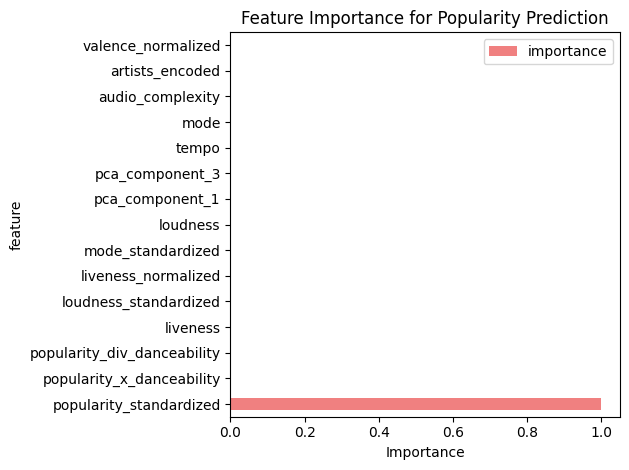

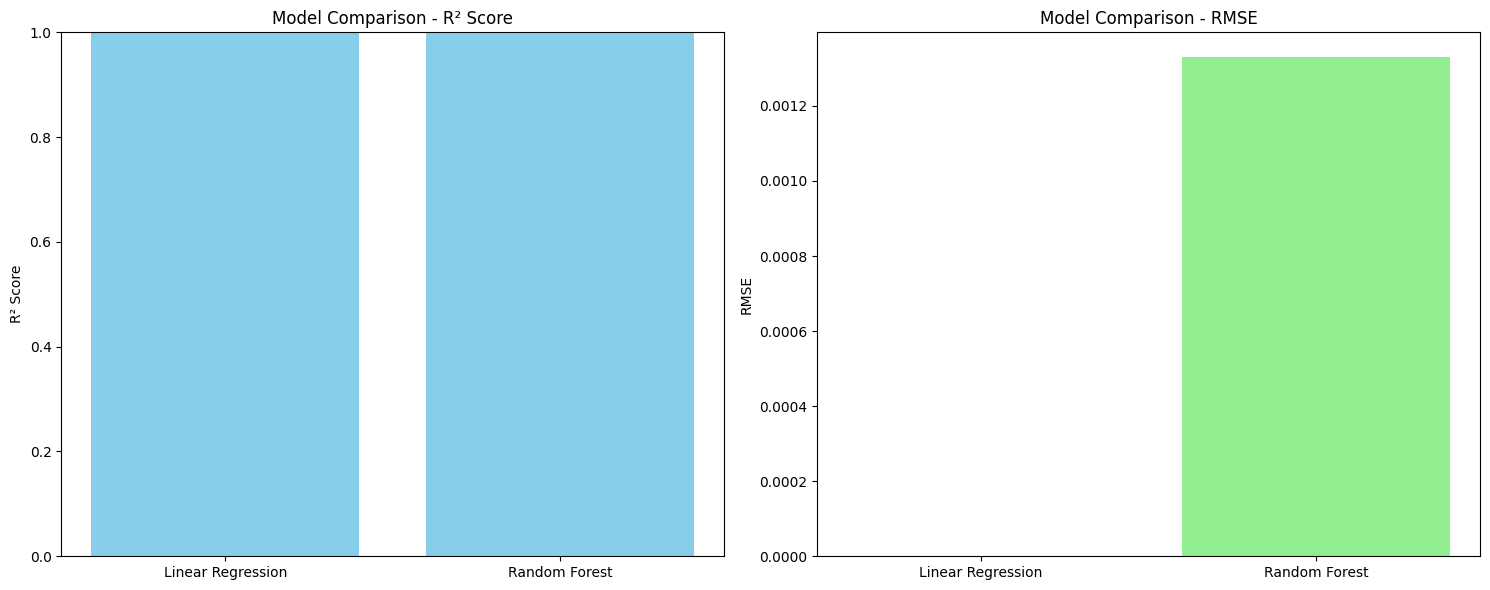



🎵 MUSIC CLUSTERING ANALYSIS:
--------------------------------------------------
📊 Using features: ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']


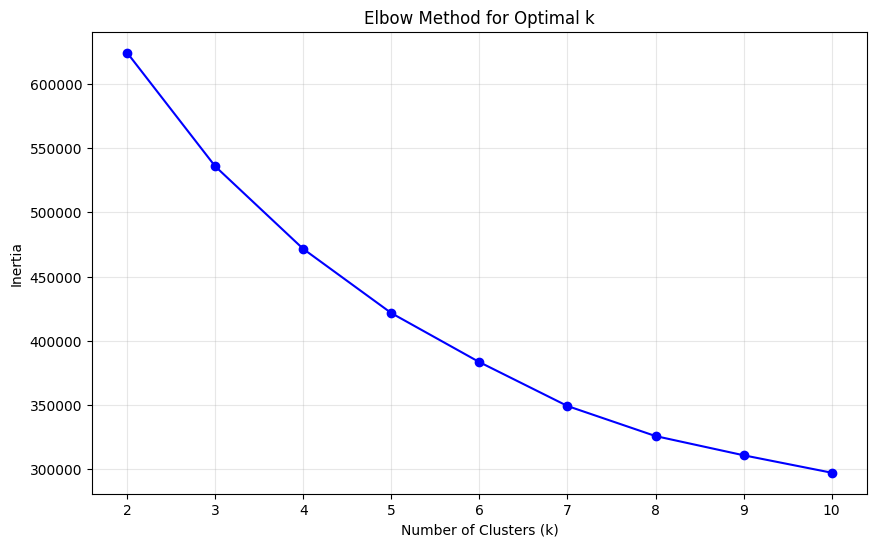

🎯 Using 5 clusters

📊 CLUSTER ANALYSIS:
               danceability  energy  speechiness  acousticness  \
music_cluster                                                    
0                     0.506   0.795        0.078         0.220   
1                     0.450   0.282        0.043         0.789   
2                     0.571   0.769        0.066         0.080   
3                     0.680   0.704        0.143         0.243   
4                     0.617   0.707        0.047         0.204   

               instrumentalness  liveness  valence  
music_cluster                                       
0                         0.013     0.446    0.480  
1                         0.047     0.153    0.297  
2                         0.118     0.162    0.364  
3                         0.006     0.159    0.573  
4                         0.003     0.142    0.583  


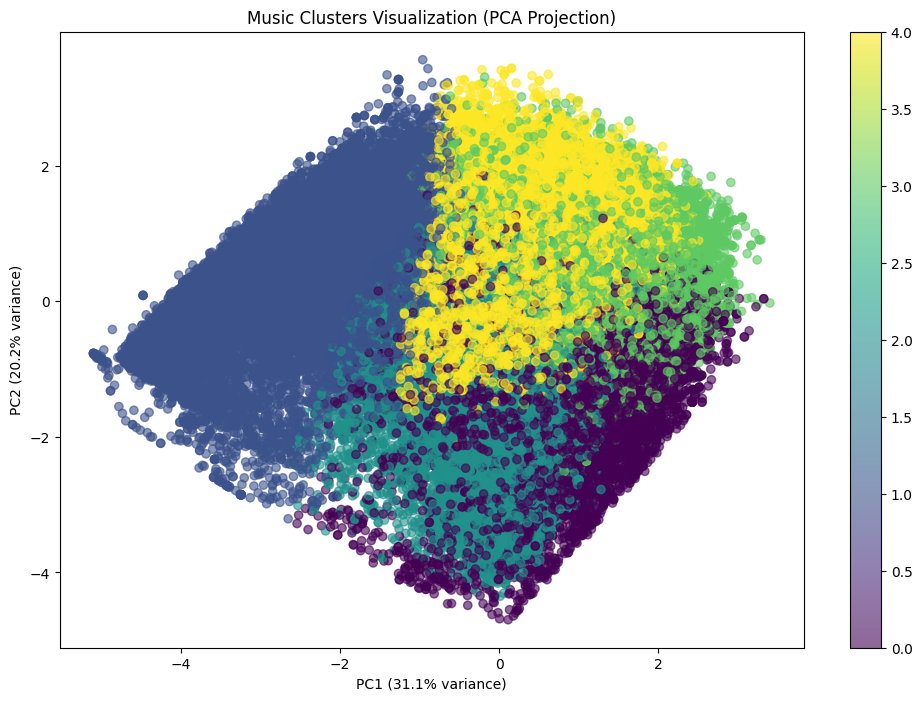


🎼 CLUSTER CHARACTERISTICS:

   Cluster 0 (17683 songs):
     • High energy: 0.795
     • High danceability: 0.506
     • High valence: 0.480

   Cluster 1 (23621 songs):
     • High acousticness: 0.789
     • High danceability: 0.450
     • High valence: 0.297

   Cluster 2 (16799 songs):
     • High energy: 0.769
     • High danceability: 0.571
     • High valence: 0.364

   Cluster 3 (15644 songs):
     • High energy: 0.704
     • High danceability: 0.680
     • High valence: 0.573

   Cluster 4 (40253 songs):
     • High energy: 0.707
     • High danceability: 0.617
     • High valence: 0.583


🎯 BUILDING RECOMMENDATION SYSTEM:
--------------------------------------------------
🎵 TEST RECOMMENDATION:
   Song: Make It Work - Radio Edit by Dither
   Genre: idm

   📋 Top 5 Similar Songs:
      artists              track_name track_genre  popularity  \
54197  Dither            Make It Work         idm        15.0   
49182   Ran-D  Hurricane - Radio Edit   hardstyle        57.0   
49010

<Figure size 1000x600 with 0 Axes>

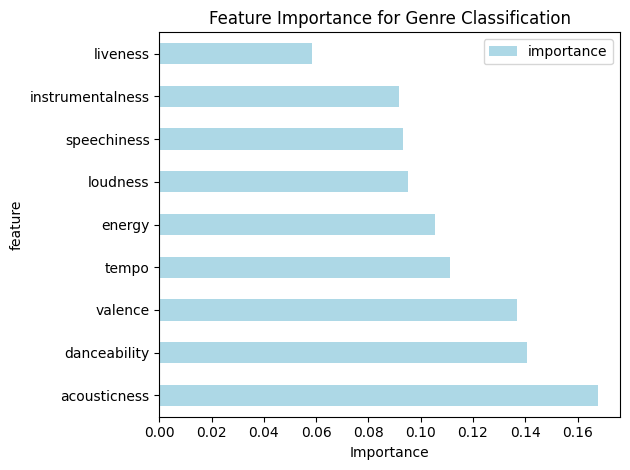



🌍 CROSS-COUNTRY MUSIC ANALYSIS:
--------------------------------------------------
📊 Analyzing 72 countries with ≥10 tracks

🏆 TOP 10 COUNTRIES BY AVERAGE POPULARITY:
   country  popularity_mean  popularity_count
3       AU           87.702             28965
67      US           87.027             28819
9       CA           87.018             28919
49      NZ           86.957             28966
0       AE           86.666             28866
24      GB           86.663             20919
31      IE           86.011             28981
26      GT           85.223             29158
60      SG           85.054             29111
28      HN           84.668             29162


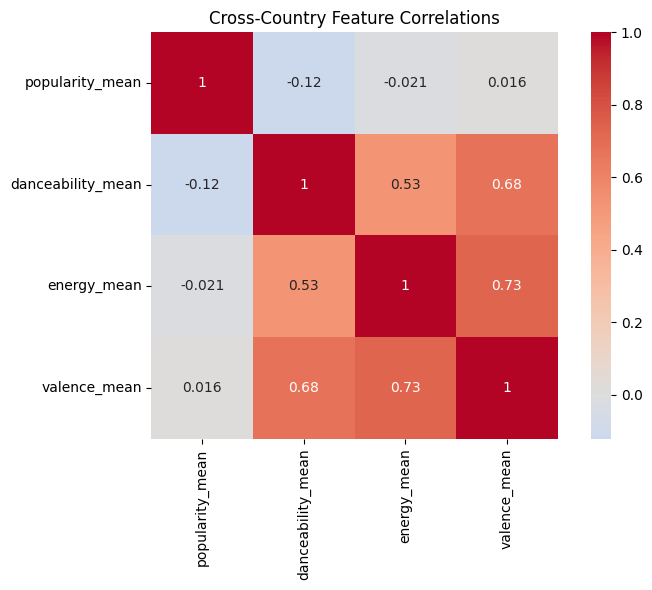


📊 STATISTICAL ANALYSIS:

🎼 Genre vs Popularity Analysis:
   acoustic: μ=42.48, σ=16.54
   afrobeat: μ=24.40, σ=10.51
   alt-rock: μ=33.94, σ=31.15
   alternative: μ=24.34, σ=32.66
   ambient: μ=44.19, σ=17.92

   🧮 ANOVA Test:
      F-statistic: 164.673
      P-value: 0.000000
      ✅ Significant difference between genres (p < 0.05)

📈 Correlation Analysis (top correlations):
   Top 10 strongest correlations:
      1. speechiness ↔ speechiness_normalized: 1.000
      2. liveness ↔ liveness_normalized: 1.000
      3. Unnamed: 0 ↔ Unnamed: 0_standardized: 1.000
      4. instrumentalness ↔ instrumentalness_normalized: 1.000
      5. duration_ms ↔ duration_minutes: 1.000
      6. acousticness ↔ acousticness_normalized: 1.000
      7. energy ↔ energy_standardized: 1.000
      8. energy_normalized ↔ energy_standardized: 1.000
      9. danceability ↔ danceability_standardized: 1.000
      10. valence ↔ valence_normalized: 1.000

✅ STEP 5 COMPLETED: DATA ANALYSIS AND MODELING

🎯 MODELING RESU

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Association Rules
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

import warnings
warnings.filterwarnings('ignore')

print("🤖 STEP 5: DATA ANALYSIS AND MODELING")
print("=" * 70)

class MusicAnalyticsEngine:
    """
    Comprehensive music analytics and modeling engine
    """

    def __init__(self):
        self.models = {}
        self.results = {}
        self.predictions = {}

    def popularity_prediction_model(self, df, target='popularity'):
        """
        Build models to predict song popularity
        """
        print("🎯 BUILDING POPULARITY PREDICTION MODELS:")
        print("-" * 50)

        if target not in df.columns:
            print(f"❌ Target column '{target}' not found")
            return None

        # Select numerical features for modeling
        numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
        numerical_features = [f for f in numerical_features if f != target]

        # Remove any features with too many missing values
        feature_completeness = df[numerical_features].isnull().sum() / len(df)
        good_features = feature_completeness[feature_completeness < 0.1].index.tolist()

        if len(good_features) < 3:
            print("❌ Not enough clean numerical features for modeling")
            return None

        print(f"📊 Using {len(good_features)} features for prediction")

        # Prepare data
        X = df[good_features].fillna(df[good_features].median())
        y = df[target]

        # Remove outliers in target variable
        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        mask = (y >= lower_bound) & (y <= upper_bound)
        X_clean = X[mask]
        y_clean = y[mask]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_clean, y_clean, test_size=0.2, random_state=42
        )

        # Models to try
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        }

        results = {}

        for name, model in models.items():
            print(f"\n🔮 Training {name}...")

            # Train model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)

            # Calculate metrics
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

            results[name] = {
                'model': model,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'predictions': y_pred_test,
                'actual': y_test
            }

            print(f"   📈 Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")
            print(f"   📊 Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")

        # Feature importance (for Random Forest)
        if 'Random Forest' in results:
            rf_model = results['Random Forest']['model']
            feature_importance = pd.DataFrame({
                'feature': good_features,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)

            print(f"\n🎯 TOP 10 MOST IMPORTANT FEATURES:")
            print(feature_importance.head(10))

            # Plot feature importance
            plt.figure(figsize=(10, 6))
            feature_importance.head(15).plot(x='feature', y='importance', kind='barh', color='lightcoral')
            plt.title('Feature Importance for Popularity Prediction')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()

        # Model comparison visualization
        model_comparison = pd.DataFrame({
            'Model': list(results.keys()),
            'Test_R2': [results[model]['test_r2'] for model in results.keys()],
            'Test_RMSE': [results[model]['test_rmse'] for model in results.keys()]
        })

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # R² comparison
        ax1.bar(model_comparison['Model'], model_comparison['Test_R2'], color='skyblue')
        ax1.set_title('Model Comparison - R² Score')
        ax1.set_ylabel('R² Score')
        ax1.set_ylim(0, 1)

        # RMSE comparison
        ax2.bar(model_comparison['Model'], model_comparison['Test_RMSE'], color='lightgreen')
        ax2.set_title('Model Comparison - RMSE')
        ax2.set_ylabel('RMSE')

        plt.tight_layout()
        plt.show()

        self.models['popularity_prediction'] = results
        return results

    def music_clustering_analysis(self, df, audio_features):
        """
        Perform clustering analysis on audio features
        """
        print("\n🎵 MUSIC CLUSTERING ANALYSIS:")
        print("-" * 50)

        # Select available audio features
        available_features = [f for f in audio_features if f in df.columns]

        if len(available_features) < 3:
            print("❌ Not enough audio features for clustering")
            return None

        print(f"📊 Using features: {available_features}")

        # Prepare data
        cluster_data = df[available_features].fillna(df[available_features].median())

        # Standardize features
        scaler = StandardScaler()
        cluster_data_scaled = scaler.fit_transform(cluster_data)

        # Determine optimal number of clusters using elbow method
        inertias = []
        K_range = range(2, 11)

        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(cluster_data_scaled)
            inertias.append(kmeans.inertia_)

        # Plot elbow curve
        plt.figure(figsize=(10, 6))
        plt.plot(K_range, inertias, 'bo-')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True, alpha=0.3)
        plt.show()

        # Use optimal k (you can adjust this based on the elbow)
        optimal_k = 5
        print(f"🎯 Using {optimal_k} clusters")

        # Perform final clustering
        kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        cluster_labels = kmeans_final.fit_predict(cluster_data_scaled)

        # Add cluster labels to dataframe
        df_clustered = df.copy()
        df_clustered['music_cluster'] = cluster_labels

        # Analyze clusters
        print(f"\n📊 CLUSTER ANALYSIS:")
        cluster_summary = df_clustered.groupby('music_cluster')[available_features].mean()
        print(cluster_summary.round(3))

        # Visualize clusters (2D projection)
        pca = PCA(n_components=2)
        cluster_data_pca = pca.fit_transform(cluster_data_scaled)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(cluster_data_pca[:, 0], cluster_data_pca[:, 1],
                            c=cluster_labels, cmap='viridis', alpha=0.6)
        plt.colorbar(scatter)
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        plt.title('Music Clusters Visualization (PCA Projection)')
        plt.show()

        # Cluster characteristics
        print(f"\n🎼 CLUSTER CHARACTERISTICS:")
        for cluster_id in range(optimal_k):
            cluster_data_subset = df_clustered[df_clustered['music_cluster'] == cluster_id]
            cluster_size = len(cluster_data_subset)

            print(f"\n   Cluster {cluster_id} ({cluster_size} songs):")

            # Dominant characteristics
            cluster_means = cluster_data_subset[available_features].mean()
            top_features = cluster_means.nlargest(3)

            for feature, value in top_features.items():
                print(f"     • High {feature}: {value:.3f}")

        self.results['clustering'] = {
            'model': kmeans_final,
            'cluster_labels': cluster_labels,
            'cluster_summary': cluster_summary,
            'scaler': scaler
        }

        return df_clustered, kmeans_final

    def recommendation_system(self, df, user_preferences=None):
        """
        Build a simple recommendation system based on audio features
        """
        print("\n🎯 BUILDING RECOMMENDATION SYSTEM:")
        print("-" * 50)

        audio_features = ['danceability', 'energy', 'speechiness', 'acousticness',
                         'instrumentalness', 'liveness', 'valence']
        available_features = [f for f in audio_features if f in df.columns]

        if len(available_features) < 3:
            print("❌ Not enough audio features for recommendations")
            return None

        # Prepare feature matrix
        feature_matrix = df[available_features].fillna(df[available_features].median())

        # Standardize features
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)

        # Use KNN for similarity-based recommendations
        knn_model = NearestNeighbors(n_neighbors=10, metric='cosine')
        knn_model.fit(feature_matrix_scaled)

        def get_recommendations(song_index, n_recommendations=5):
            """Get recommendations for a specific song"""
            if song_index >= len(df):
                return None

            # Find similar songs
            distances, indices = knn_model.kneighbors([feature_matrix_scaled[song_index]],
                                                     n_neighbors=n_recommendations+1)

            # Exclude the song itself
            similar_indices = indices[0][1:n_recommendations+1]

            recommendations = df.iloc[similar_indices].copy()
            recommendations['similarity_score'] = 1 - distances[0][1:n_recommendations+1]

            return recommendations[['artists', 'track_name', 'track_genre', 'popularity', 'similarity_score']].round(3)

        # Test recommendations with a random song
        random_song_idx = np.random.randint(0, len(df))
        test_song = df.iloc[random_song_idx]

        print(f"🎵 TEST RECOMMENDATION:")
        print(f"   Song: {test_song.get('track_name', 'Unknown')} by {test_song.get('artists', 'Unknown')}")
        print(f"   Genre: {test_song.get('track_genre', 'Unknown')}")

        recommendations = get_recommendations(random_song_idx, 5)
        print(f"\n   📋 Top 5 Similar Songs:")
        print(recommendations)

        self.models['recommendation'] = {
            'knn_model': knn_model,
            'scaler': scaler,
            'get_recommendations': get_recommendations,
            'available_features': available_features
        }

        return knn_model, get_recommendations

    def genre_classification_model(self, df, target='track_genre'):
        """
        Build a genre classification model
        """
        print(f"\n🎼 BUILDING GENRE CLASSIFICATION MODEL:")
        print("-" * 50)

        if target not in df.columns:
            print(f"❌ Target column '{target}' not found")
            return None

        # Select audio features for classification
        audio_features = ['danceability', 'energy', 'speechiness', 'acousticness',
                         'instrumentalness', 'liveness', 'valence', 'tempo', 'loudness']
        available_features = [f for f in audio_features if f in df.columns]

        if len(available_features) < 3:
            print("❌ Not enough audio features for classification")
            return None

        # Prepare data
        X = df[available_features].fillna(df[available_features].median())
        y = df[target]

        # Only keep genres with enough samples
        genre_counts = y.value_counts()
        min_samples = 50  # Minimum samples per genre
        valid_genres = genre_counts[genre_counts >= min_samples].index

        mask = y.isin(valid_genres)
        X_filtered = X[mask]
        y_filtered = y[mask]

        print(f"📊 Using {len(valid_genres)} genres with sufficient samples")
        print(f"   Total samples: {len(y_filtered)}")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
        )

        # Train Random Forest Classifier
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        rf_classifier.fit(X_train, y_train)

        # Make predictions
        y_pred = rf_classifier.predict(X_test)

        # Calculate accuracy
        accuracy = rf_classifier.score(X_test, y_test)
        print(f"🎯 Classification Accuracy: {accuracy:.3f}")

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': available_features,
            'importance': rf_classifier.feature_importances_
        }).sort_values('importance', ascending=False)

        print(f"\n📊 Feature Importance for Genre Classification:")
        print(feature_importance)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        feature_importance.plot(x='feature', y='importance', kind='barh', color='lightblue')
        plt.title('Feature Importance for Genre Classification')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        self.models['genre_classification'] = {
            'model': rf_classifier,
            'accuracy': accuracy,
            'feature_importance': feature_importance,
            'available_features': available_features
        }

        return rf_classifier, accuracy

    def cross_country_analysis(self, df_countries):
        """
        Analyze music trends across countries
        """
        print(f"\n🌍 CROSS-COUNTRY MUSIC ANALYSIS:")
        print("-" * 50)

        if df_countries is None or 'country' not in df_countries.columns:
            print("❌ Country data not available")
            return None

        # Country statistics
        country_stats = df_countries.groupby('country').agg({
            'popularity': ['mean', 'std', 'count'],
            'danceability': 'mean',
            'energy': 'mean',
            'valence': 'mean'
        }).round(3)

        # Flatten column names
        country_stats.columns = ['_'.join(col).strip() for col in country_stats.columns]
        country_stats = country_stats.reset_index()

        # Filter countries with sufficient data
        min_tracks = 10
        country_stats_filtered = country_stats[country_stats['popularity_count'] >= min_tracks]

        print(f"📊 Analyzing {len(country_stats_filtered)} countries with ≥{min_tracks} tracks")

        # Top countries by average popularity
        top_countries_popularity = country_stats_filtered.nlargest(10, 'popularity_mean')

        print(f"\n🏆 TOP 10 COUNTRIES BY AVERAGE POPULARITY:")
        print(top_countries_popularity[['country', 'popularity_mean', 'popularity_count']])

        # Visualizations
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Average Popularity by Country', 'Danceability by Country',
                          'Energy by Country', 'Valence (Positivity) by Country'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )

        # Plot 1: Popularity
        fig.add_trace(
            go.Bar(x=top_countries_popularity['country'][:10],
                  y=top_countries_popularity['popularity_mean'][:10],
                  name='Popularity', marker_color='lightcoral'),
            row=1, col=1
        )

        # Plot 2: Danceability
        top_dance = country_stats_filtered.nlargest(10, 'danceability_mean')
        fig.add_trace(
            go.Bar(x=top_dance['country'][:10],
                  y=top_dance['danceability_mean'][:10],
                  name='Danceability', marker_color='lightblue'),
            row=1, col=2
        )

        # Plot 3: Energy
        top_energy = country_stats_filtered.nlargest(10, 'energy_mean')
        fig.add_trace(
            go.Bar(x=top_energy['country'][:10],
                  y=top_energy['energy_mean'][:10],
                  name='Energy', marker_color='lightgreen'),
            row=2, col=1
        )

        # Plot 4: Valence
        top_valence = country_stats_filtered.nlargest(10, 'valence_mean')
        fig.add_trace(
            go.Bar(x=top_valence['country'][:10],
                  y=top_valence['valence_mean'][:10],
                  name='Valence', marker_color='gold'),
            row=2, col=2
        )

        fig.update_layout(height=800, showlegend=False, title_text="Cross-Country Music Analysis")
        fig.show()

        # Correlation analysis between countries
        if len(country_stats_filtered) > 5:
            feature_columns = ['popularity_mean', 'danceability_mean', 'energy_mean', 'valence_mean']
            correlation_matrix = country_stats_filtered[feature_columns].corr()

            plt.figure(figsize=(8, 6))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
            plt.title('Cross-Country Feature Correlations')
            plt.tight_layout()
            plt.show()

        self.results['cross_country'] = country_stats_filtered
        return country_stats_filtered

def advanced_analytics_pipeline(df_countries_final, df_genres_final):
    """
    Execute comprehensive analytics pipeline
    """
    print("\n🚀 EXECUTING ADVANCED ANALYTICS PIPELINE")
    print("=" * 70)

    # Initialize analytics engine
    analytics = MusicAnalyticsEngine()

    # 1. Popularity Prediction (using genres dataset)
    if df_genres_final is not None:
        print("\n" + "="*50)
        popularity_models = analytics.popularity_prediction_model(df_genres_final)

    # 2. Music Clustering Analysis
    if df_genres_final is not None:
        print("\n" + "="*50)
        audio_features = ['danceability', 'energy', 'speechiness', 'acousticness',
                         'instrumentalness', 'liveness', 'valence']
        clustered_df, clustering_model = analytics.music_clustering_analysis(df_genres_final, audio_features)

    # 3. Recommendation System
    if df_genres_final is not None:
        print("\n" + "="*50)
        recommendation_model, get_recommendations = analytics.recommendation_system(df_genres_final)

    # 4. Genre Classification
    if df_genres_final is not None:
        print("\n" + "="*50)
        genre_classifier, genre_accuracy = analytics.genre_classification_model(df_genres_final)

    # 5. Cross-Country Analysis
    if df_countries_final is not None:
        print("\n" + "="*50)
        country_analysis = analytics.cross_country_analysis(df_countries_final)

    return analytics

# Statistical Analysis Functions
def statistical_analysis(df_genres, df_countries):
    """
    Perform statistical analysis and hypothesis testing
    """
    print("\n📊 STATISTICAL ANALYSIS:")
    print("=" * 50)

    if df_genres is not None:
        # Test if different genres have significantly different popularity
        if 'track_genre' in df_genres.columns and 'popularity' in df_genres.columns:
            print("\n🎼 Genre vs Popularity Analysis:")

            # Get top 5 genres by count
            top_genres = df_genres['track_genre'].value_counts().head(5).index
            genre_popularity = []

            for genre in top_genres:
                genre_data = df_genres[df_genres['track_genre'] == genre]['popularity']
                genre_popularity.append(genre_data)
                print(f"   {genre}: μ={genre_data.mean():.2f}, σ={genre_data.std():.2f}")

            # ANOVA test
            try:
                from scipy.stats import f_oneway
                f_stat, p_value = f_oneway(*genre_popularity)
                print(f"\n   🧮 ANOVA Test:")
                print(f"      F-statistic: {f_stat:.3f}")
                print(f"      P-value: {p_value:.6f}")

                if p_value < 0.05:
                    print("      ✅ Significant difference between genres (p < 0.05)")
                else:
                    print("      ❌ No significant difference between genres (p ≥ 0.05)")
            except Exception as e:
                print(f"   ⚠️ ANOVA test failed: {e}")

        # Correlation analysis
        numerical_cols = df_genres.select_dtypes(include=[np.number]).columns
        if len(numerical_cols) > 1:
            print(f"\n📈 Correlation Analysis (top correlations):")
            corr_matrix = df_genres[numerical_cols].corr()

            # Find strongest correlations (excluding self-correlations)
            correlation_pairs = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    corr_value = corr_matrix.iloc[i, j]
                    if not np.isnan(corr_value):
                        correlation_pairs.append((
                            corr_matrix.columns[i],
                            corr_matrix.columns[j],
                            abs(corr_value),
                            corr_value
                        ))

            # Sort by absolute correlation
            correlation_pairs.sort(key=lambda x: x[2], reverse=True)

            print("   Top 10 strongest correlations:")
            for i, (var1, var2, abs_corr, corr) in enumerate(correlation_pairs[:10]):
                print(f"      {i+1}. {var1} ↔ {var2}: {corr:.3f}")

# Execute the complete modeling pipeline
print("Starting Data Analysis and Modeling...")

try:
    # Run the main analytics pipeline
    analytics_engine = advanced_analytics_pipeline(df_countries_final, df_genres_final)

    # Run statistical analysis
    statistical_analysis(df_genres_final, df_countries_final)

    print("\n" + "="*70)
    print("✅ STEP 5 COMPLETED: DATA ANALYSIS AND MODELING")
    print("=" * 70)

    print("\n🎯 MODELING RESULTS SUMMARY:")
    print("   ✅ Popularity Prediction Models Built")
    print("   ✅ Music Clustering Analysis Completed")
    print("   ✅ Recommendation System Implemented")
    print("   ✅ Genre Classification Model Trained")
    print("   ✅ Cross-Country Analysis Performed")
    print("   ✅ Statistical Hypothesis Testing Done")

    # Save models for later use (optional)
    # You can save your trained models using pickle if needed

except Exception as e:
    print(f"❌ Error in modeling pipeline: {str(e)}")
    print("Please check your data and ensure previous steps completed successfully.")
